# Superoscillation FMQA

## 名詞定義
<pre>
- config, configs
  - config  : 一個zone plate的組態
  - configs : 多個zone plates的組態
- fom, foms
  - fom  : 一個zone plate的組態對應的fom
  - foms : 多個zone plates的組態對應的fom 
- ring, rings
  - ring  : 一個環的狀態（0或1）
  - rings : 一個zone plate的環數
</pre>

## Note
<pre>
- SA不會將相同的結果自動合併(aggregate)，QA會 -> this is not a problem when sampling many times
</pre>

## 進度（更新時間：2025/4/10 4:30am）
<pre>
(required)
- read_file, add_new_data還沒完成
- simulation部分的不允許重複數據還需要修正
- 固定刪除前幾%的數據要寫成函數，然後這樣做的話最後的FOM圖就要刪除紅線（因為已經無法區分哪些是初始數據了）
(optional)
- save_file的部分還要再存intensity的數據
- exact solver的add_new_data目前還是另外設定的
- 把data統一存在一個PostgreSQL資料庫 -> 支持array(but not numpy)
- 除了計算FOMs的函式之外，不應該有關於物理問題的部分（其他會使用到foms_calc的參數應該要用*args, *kwargs來傳） -> 通用性
</pre>

In [1]:
import os
import sys
import glob
import time
import math
import shutil
import random
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from zone_plate import ZonePlate
import S4
from scipy import integrate


# Setting Environment Variable (Has to be set before importing mxnet, or it will use multiprocessing automatically)
os.environ['MXNET_CPU_WORKER_NTHREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'

# Factorization Machine
import mxnet as mx
from mxnet import nd
from factorization_machine import FactorizationMachine as OriginalFactorizationMachine
mx.random.seed(int(time.time()))

# QUBO Sampler
import dimod
from dwave.system import DWaveSampler, EmbeddingComposite, FixedEmbeddingComposite

In [2]:
class FactorizationMachine(OriginalFactorizationMachine):

    def __call__(self, xs):
        """Override __call__ to handle numpy array input automatically."""
        if isinstance(xs, np.ndarray):
            xs = nd.array(xs)  # 自動轉換 numpy 陣列
        return super().__call__(xs)
    
    def loss(self, dataset):
        """
        用途：計算loss
        計算公式：mean((ys - outputs)**2)
    
        參數
        - dataset: [xs, ys]
        """
        xs = nd.array(dataset[0])
        ys = nd.array(dataset[1])
        return nd.mean( ( ys - self(xs) ) ** 2 ).asscalar()

    def _get_bhQ_scaled(self, scaling=True):
        """
        原始程式有做scaling
        """
        b, h, Q = self.get_bhQ()  # b: bias, h: linear, Q: quadratic (上三角部分)，皆為 numpy array
        # print(h)
        
        h_max = np.max(np.abs(h))
        Q_max = np.max(np.abs(Q))
        scaling_factor = max(h_max, Q_max)
        # print(scaling_factor)
        if scaling:
            b /= scaling_factor
            h /= scaling_factor
            Q /= scaling_factor
        # print(h)
        # sys.exit(1)

        return b, h, Q

    def bqm(self):
        """
        用途：從 model 得到 bqm
        """
        #b, h, Q = self.get_bhQ()
        b, h, Q = self._get_bhQ_scaled()    # b: bias, h: linear, Q: quadratic (上三角部分)，皆為 numpy array

        offset = b.item()  # 將 numpy array 轉為 Python 數值
        linear = {i: h[i] for i in range(Q.shape[0])}
        quadratic = {(i, j): Q[i, j] for i in range(Q.shape[0]) for j in range(i + 1, Q.shape[1])}

        # BQM(linear, quadratic, offset, vartype)
        return dimod.BinaryQuadraticModel(linear, quadratic, offset, dimod.BINARY)

    def plot_Q_matrix(self, show_fig=False, path_fig="Q_matrix_heatmap.png", save_fig=True, path_data="Q_matrix.npy", save_data=True):
        """
        用途：畫Q matrix的heatmap
        """
        #b, h, Q = self.get_bhQ()
        b, h, Q = self._get_bhQ_scaled()    # bias, linear, qudratic(upper tri)
        Q = Q + Q.T
        np.fill_diagonal(Q, h)
        
        if save_data:
            np.save(path_data, Q)

        if show_fig or save_fig:
            plt.figure()
            plt.imshow(Q, cmap="bwr")
            plt.colorbar()  # 顯示顏色對應的數值
            plt.title("Q Matrix Heatmap")

            if save_fig:
                plt.savefig(path_fig, bbox_inches='tight')
            if show_fig:
                plt.show()
            else:
                plt.close()

    def save_model(self, path="model.params"):
        """
        用途：儲存model參數、optimizer狀態
        """
        mx.nd.waitall()
        # start_time = time.time()
        self.save_parameters(path)
        # end_time = time.time()
        # print(f"save parameters spend: {end_time - start_time} sec")
        
        if self.trainer is not None:
            # start_time = time.time()
            self.trainer.save_states(path + ".trainer")
            # end_time = time.time()
            # print(f"save optimizer states spend: {end_time - start_time} sec")

    @staticmethod
    def load_model(var_num, K, path="model.params"):
        """
        用途：讀取並返回model參數、optimizer狀態

        參數
        - var_num : qubits數
        - K       : Factorization Machine的K
        """
        model = FactorizationMachine(input_size=var_num, factorization_size=K, act="identity")
        model.load_parameters(path, ctx=mx.cpu())

        # 需要先初始化 Trainer，然後才能載入 state
        model.trainer = mx.gluon.Trainer(model.collect_params(), "adam")

        try:
            model.trainer.load_states(path + ".trainer")
        except FileNotFoundError:
            print("沒有讀到optimizer的參數")

        return model

In [3]:
embedding_params_8 = {1: (5228, 5227, 1377, 1378, 5229, 5231, 5230, 2217),
                    0: (5092, 5093, 5094, 1468, 5095, 5096, 1467, 5317, 1393, 1394, 1469),
                    2: (1931, 1930, 1932, 1933, 4886, 4885, 1934, 1929),
                    3: (2066, 2067, 5020, 5019, 2065, 5018, 2068, 2069, 5017, 1421),
                    4: (1811, 1810, 4855, 1812, 1813, 4854, 1814),
                    5: (5258, 5257, 5259, 5260, 5256, 1182, 1183, 1273, 1274, 5261, 2247),
                    6: (5077, 1498, 1497, 1499, 5078, 5079, 5080, 5081),
                    7: (2054, 5590, 5589, 2053, 2052, 2051, 5588, 5681, 2050, 5591),
                    8: (5528, 5529, 5530, 5531, 5527, 1664, 2233, 5526),
                    9: (5469, 5470, 5468, 5467, 5471, 1348, 1347, 5472, 1346, 5107),
                    10: (1766, 1767, 4959, 4960, 4961, 1768, 4988, 1769, 1765),
                    11: (1363, 5408, 5409, 5410, 5411, 5407, 1453),
                    12: (5425, 5424, 5423, 5422, 1318, 5426, 1603, 5421, 1198),
                    13: (5153, 5152, 5156, 1422, 1423, 1424, 5154, 5155),
                    14: (1660, 4868, 1570, 1571, 1572, 1573, 1574, 1661, 4779, 4780, 4781, 4944),
                    15: (1690, 1691, 1692, 1693, 4974, 4975, 4976, 4977, 2201, 1694),
                    16: (1798, 1797, 5139, 5138, 1796, 1799, 5634, 5559, 5560, 5561),
                    17: (5243, 5244, 5245, 5246, 1542, 1543, 1677, 5242, 1544),
                    18: (5184, 1826, 1827, 4840, 1828, 4839, 1829, 1825),
                    19: (5514, 5515, 5516, 5513, 5512, 5511, 5517),
                    20: (4871, 4869, 1751, 1752, 1754, 1750, 1753, 4870),
                    21: (4751, 1841, 4749, 1842, 1843, 4750, 1840, 1844),
                    22: (2081, 2080, 2082, 2083, 2084, 4946, 2079, 4810, 4809, 1795),
                    23: (5543, 1604, 5544, 5542, 5541, 5545, 5546),
                    24: (4913, 1631, 1632, 1633, 4914, 4915, 1634, 4916),
                    25: (5438, 5439, 1454, 5440, 5441, 5437, 5436, 5442, 2293, 2292, 5292),
                    26: (5575, 5574, 5573, 5572, 5576, 2219, 2218, 5571),
                    27: (5305, 2173, 5306, 5304, 2174, 2172, 5303),
                    28: (2143, 2144, 5321, 5320, 5319, 2142, 2141, 5318),
                    29: (5484, 5485, 5486, 5483, 5482, 1333, 1332, 5487),
                    30: (5108, 1541, 5048, 5049, 5050, 1482, 1483, 1484, 5051),
                    31: (1946, 1945, 1947, 1948, 1949, 4824, 4825, 1944),
                    32: (4720, 1721, 2049, 4721, 4719, 1719, 1720, 1722, 1723, 1724),
                    33: (1303, 5333, 5332, 5334, 5335, 5336, 1304, 1302, 1408, 5601),
                    34: (1962, 1961, 1960, 1959, 1963, 1964, 5620, 5619),
                    35: (5274, 5275, 5272, 5273, 1707, 1708, 5276),
                    36: (1856, 4615, 1857, 4616, 1858, 1854, 1855, 1859),
                    37: (4928, 4929, 1555, 1556, 1557, 1558, 1559, 4930, 4931),
                    38: (1901, 1902, 1903, 1904, 5650, 5651, 1900, 1899, 1898, 4629, 4630),
                    39: (5349, 5350, 1872, 1873, 5348, 5351, 1871, 5347),
                    40: (1586, 1587, 5064, 5063, 5065, 5066, 1588, 1589, 4958),
                    41: (5496, 5497, 5499, 5500, 5502, 5501, 5498),
                    42: (2007, 2008, 2009, 2006, 4945, 2005),
                    43: (1782, 1781, 1780, 1783, 5199, 5200, 1784, 1779),
                    44: (1734, 1735, 1736, 1737, 4736, 1738, 4734, 4735, 1739),
                    45: (1977, 1978, 1976, 1975, 1979, 1974),
                    46: (1885, 1884, 4659, 4660, 1886, 1887, 1888, 1889, 2004),
                    47: (5363, 5364, 5362, 1527, 1438, 5366, 5365, 1439),
                    48: (1992, 1993, 1990, 1994, 1991, 4765),
                    49: (5290, 5289, 5288, 5287, 5291, 1678, 1679),
                    50: (2204, 5606, 5112, 5605, 5604, 5603, 2203, 2202, 5602),
                    51: (2112, 2113, 2114, 2111, 2110, 2109, 5380),
                    52: (1646, 1647, 1648, 1649, 4898, 4899, 5378, 4900, 4901),
                    53: (5453, 5454, 5455, 5456, 2248, 5452),
                    54: (5003, 1616, 1617, 1618, 5004, 5005, 1619, 1615, 5006),
                    55: (2037, 2038, 2039, 2036, 5215, 5214, 2035, 5213, 5212, 2034),
                    56: (2096, 2095, 2097, 2098, 2099, 2094, 5185, 2093, 5141),
                    57: (2021, 2020, 2019, 2022, 2023, 2024, 4990, 4690),
                    58: (5111, 2156, 2155, 5110, 5109, 2157, 2158, 2159),
                    59: (5032, 1436, 1437, 1511, 1512, 1513, 5033, 5034, 5035, 1514, 1706),
                    60: (2126, 2127, 2124, 2128, 2129, 5170, 2125, 5169),
                    61: (2187, 5126, 2188, 2189, 2186, 5125, 5124, 2185, 5123),
                    62: (5393, 5394, 5395, 5392, 5391, 5396, 1258, 1528, 1257, 5226, 5151),
                    63: (1917, 1918, 1916, 1915, 1919, 5379, 1914, 5140)}

In [4]:
# 定義Zone Plate的參數
rings      = 60        # 定義一個zone plate的環數
multiple   = 8.0       # 定義焦平面要算到幾倍波長（不能小於target_max_multiple）
resolution = 2_000     # 定義要將

# 定義計算FOM的參數
####################################
target_method       = "intuitive3"
target_max_multiple = 8.0
target_threshold    = 0.4
beta                = 10
#####################################
# target_method              = "step"
# target_max_multiple        = 8.0
# target_step_point_multiple = 0.3
##################################

if (target_method == "intuitive") or (target_method == "intuitive2") or (target_method == "intuitive3"):
    target = [target_method, target_max_multiple, target_threshold, beta, resolution]
elif (target_method == "step"):
    target = [target_method, target_max_multiple, target_step_point_multiple]
else:
    print("沒有這個target method")
    sys.exit(1)

# 定義初始數據的參數
init_dataset_size          = 1000                                                 # read_file的參數n（包含訓練集、測試集）
init_dataset_method        = "read_n"                                             # read_file的參數method
init_dataset_top_k_percent = 1                                                    # read_file的參數k
init_dataset_fom_thresh    = 0.4                                                  # read_file的參數thresh
init_dataset_repeat        = True                                                 # read_file的參數repeat
init_dataset_split_ratio   = 1                                                    # 多少比例要成為training set（testing筆數可以為0，但就不能用dynamic_FM）
init_trainset_size         = int(init_dataset_size * init_dataset_split_ratio)    # 訓練集筆數
init_testset_size          = init_dataset_size - init_trainset_size               # 測試集筆數
if (init_trainset_size <= 0) or (init_testset_size < 0):
    print(f"訓練集or測試集筆數有問題（訓練集>0；測試集>=0）")
    print(f"訓練集筆數: {init_trainset_size}")
    print(f"測試集筆數: {init_testset_size}")
    sys.exit(1)

# 定義FMQA整個迴圈的參數
K                       = 8                              # Factorization Machine的參數K
use_dynamic_FM          = False                          # 要不要用dynamic_FM
dynamic_retrain         = False                          # dynamic_FM的參數
ignore_original_dataset = False                          # （還沒新增）
num_epoch               = 1_000                          # 不用dynamic_FM的話，FM要跑幾個epochs
iteration               = 300                            # FMQA整個流程的iteration次數
add_method              = "min_fom"                      # add_new_data的參數
dynamic_sampling        = False                          # 要不要使用num_reads_adds_generator函數 -> 依照dataset筆數來決定要sample幾次、加多少新數據到原dataset（這個為True就設定num_adds_ratio, num_reads_ratio, num_adds_limit，然後num_adds, num_reads可以忽略）
num_adds_ratio          = 0.1                            # num_reads_adds_generator的參數 -> 每個iteration要新增dataset筆數的幾倍的新數據
num_reads_ratio         = 2                              # num_reads_adds_generator的參數 -> 每個iteration的sampling次數（這邊要寫新增數據筆數的幾倍）
num_adds_limit          = 10                             # num_reads_adds_generator的參數 -> 設定num_adds的上限（不設定上限的話就設None）
num_adds                = 10                             # 每個iteration要新增多少筆新數據（num_adds <= num_reads）
num_reads               = 20                             # 每個iteration的sampling次數（這邊直接寫數字）
new_data_split_ratio    = init_dataset_split_ratio
if num_adds > num_reads:
    print("num_adds > num_reads")
    sys.exit(1)

# 定義要使用的QUBO Sampler
sampler_type = "QA"
if sampler_type == "Exact":
    if rings <= 16:
        sampler = dimod.ExactSolver()
    else:
        print("環數太多，不能使用Exact Solver")
        sys.exit(1)
elif sampler_type == "SA":
    sampler = dimod.SimulatedAnnealingSampler()
elif sampler_type == "QA":
    annealing_time = 20.0    # 定義QA QUBO sampler的annealing time（單位：µs）
    task_name = "QA_Task_jiajun"
    qpu_advantage = DWaveSampler(solver={'chip_id': 'Advantage_system6.4'})
    sampler = FixedEmbeddingComposite(qpu_advantage,embedding_params_8)
    #sampler = EmbeddingComposite(DWaveSampler(solver = {"name": "Advantage_system6.4"}))
    print(f"使用的QPU: {sampler.child.properties.get('chip_id', 'NONE')}")
    print(f"QPU預設的Annealing Time: {sampler.child.properties['default_annealing_time']} µs")
    print(f"設定QPU的Annealing Time: {annealing_time} µs")
else:
    print("沒有這個QUBO sampler")
    sys.exit(1)

# 顯示設定數據（尚未完成）
print("*****顯示設定數據*****")
print(f"訓練集筆數：{init_trainset_size}")
print(f"測試集比數：{init_testset_size}")
print("*****　顯示結束　*****")

使用的QPU: Advantage_system6.4
QPU預設的Annealing Time: 20.0 µs
設定QPU的Annealing Time: 20.0 µs
*****顯示設定數據*****
訓練集筆數：1000
測試集比數：0
*****　顯示結束　*****


## 定義函式
<pre>
generate_unique_binary_array : (generate by DeepSeek, haven't been tested)
foms_calc                    : Calculate the FOMs of the correspoding configs
save_file                    : Save the configs and the corresponding intensities and FOMs to a specific path
read_file                    : Read the configs and the corresponding FOMs from a specific path
num_reads_adds_generator     : Define the quantity of num_reads and num_adds (for dynamic_sampling)
add_new_data                 : Return the new data to be added to the training set and the testing set (use after sampling)
sort_new_data                : Sort the new data (use after calling add_new_data)
find_indices                 : (for the exact solver)
plot_foms                    : 畫foms跟foms_modified的圖
rm_best_model                : 
dynamic_FM                   : 返回testing loss最小的model（附：畫model的loss-epochs圖）
plot_loss_iter               : 畫出每個iteration的training loss跟testing loss
plot_energy_fom              : 畫出FMQA訓練過程中sample出的energy跟fom對i-th configuration的curve
</pre>

In [5]:
total_layer = 30
print_spectrum = 0
print_TR_percent = 0
sio2_thick = 0.01
ag_thick = 0.005
hfo2_thick = 0.01
al2o3_thick = 0.01
al_thick = 0.005
def n_al2o3(wl):
    nsq = 1 + 1.4313493*wl**2/(wl**2-0.0726631**2) + 0.65054713*wl**2/(wl**2-0.1193242**2) + 5.3414021*wl**2/(wl**2-18.028251**2)
    return (nsq)
def n_sio2(wl):
    nsq = 1 + 0.6961663*wl**2/(wl**2-0.0684043**2) + 0.4079426*wl**2/(wl**2-0.1162414**2) + 0.8974794*wl**2/(wl**2-9.896161**2)
    return (nsq)
def n_hfo2(wl):
    return (np.square(1.875 + 6.28e-3/(wl**2) + 5.8e-4/(wl**4)))

def s4_multilayer_FOM(x):
    #新しいシミュレーションオブジェクトを設定
    S=S4.New(Lattice=((1,0),(0,1)),NumBasis=1)
    #S.SetOptions(PolarizationDecomposition = True)
    pmma_string = 'PMMA'
    sio2_string = 'SiO2'
    sic_string  = 'SiC' 
    #materialの設定
    S.SetMaterial(Name='Vacuum',Epsilon=1)
    S.SetMaterial(Name='Si',Epsilon=3.4**2)
    S.SetMaterial(Name='SiO2',Epsilon=1.5**2)
    S.SetMaterial(Name='SiC',Epsilon=3.0**2)
    S.SetMaterial(Name='PMMA',Epsilon=1.48**2)
    S.SetMaterial(Name='Ag',Epsilon=5**2)
    S.SetMaterial(Name='HfO2',Epsilon=5**2)
    S.SetMaterial(Name='Al2O3',Epsilon=5**2)
    S.SetMaterial(Name='Al',Epsilon=5**2)
    #レイヤーを設定今回は3つのレイヤー。
   
        
        
    S.AddLayer(Name='Level0',Thickness=0.0, Material='Vacuum')
    
    if(x[(total_layer-4)*2]==0 and x[(total_layer-4)*2+1]==0):
        sio2_thick = 0.005
    elif(x[(total_layer-4)*2]==0 and x[(total_layer-4)*2+1]==1):
        sio2_thick = 0.01
    elif(x[(total_layer-4)*2]==1 and x[(total_layer-4)*2+1]==0):
        sio2_thick = 0.015
    elif(x[(total_layer-4)*2]==1 and x[(total_layer-4)*2+1]==1):
        sio2_thick = 0.02

    if(x[(total_layer-3)*2]==0 and x[(total_layer-3)*2+1]==0):
        ag_thick = 0.005
    elif(x[(total_layer-3)*2]==0 and x[(total_layer-3)*2+1]==1):
        ag_thick = 0.006
    elif(x[(total_layer-3)*2]==1 and x[(total_layer-3)*2+1]==0):
        ag_thick = 0.007
    elif(x[(total_layer-3)*2]==1 and x[(total_layer-3)*2+1]==1):
        ag_thick = 0.008

    if(x[(total_layer-2)*2]==0 and x[(total_layer-2)*2+1]==0):
        hfo2_thick = 0.005
    elif(x[(total_layer-2)*2]==0 and x[(total_layer-2)*2+1]==1):
        hfo2_thick = 0.01
    elif(x[(total_layer-2)*2]==1 and x[(total_layer-2)*2+1]==0):
        hfo2_thick = 0.015
    elif(x[(total_layer-2)*2]==1 and x[(total_layer-2)*2+1]==1):
        hfo2_thick = 0.02

    if(x[(total_layer-1)*2]==0 and x[(total_layer-1)*2+1]==0):
        al2o3_thick = 0.005
    elif(x[(total_layer-1)*2]==0 and x[(total_layer-1)*2+1]==1):
        al2o3_thick = 0.01
    elif(x[(total_layer-1)*2]==1 and x[(total_layer-1)*2+1]==0):
        al2o3_thick= 0.015
    elif(x[(total_layer-1)*2]==1 and x[(total_layer-1)*2+1]==1):
        al2o3_thick = 0.02
    
        
    
    
    for layercount in range(total_layer-4):
        if(x[layercount]==0 and x[layercount+total_layer-4]==0):
            S.AddLayer(Name=str(layercount), Thickness=sio2_thick, Material='SiO2')
        elif(x[layercount]==0 and x[layercount+total_layer-4]==1):
            S.AddLayer(Name=str(layercount), Thickness=ag_thick, Material='Ag')
        elif(x[layercount]==1 and x[layercount+total_layer-4]==0):
            S.AddLayer(Name=str(layercount), Thickness=hfo2_thick, Material='HfO2')
        elif(x[layercount]==1 and x[layercount+total_layer-4]==1):
            S.AddLayer(Name=str(layercount), Thickness=al2o3_thick, Material='Al2O3')
    
   
    
    
    S.AddLayer(Name='Air',Thickness=0.0,Material='Vacuum')
    #S.AddLayerCopy(Name = 'Air', Thickness = 0.0, Layer = 'Level0')
    
    #波長範囲を設定
    wavelength_array=np.linspace(0.4,2,80)
    #print(wavelength_array)
    wavelength_array_inside = [0.4      , 0.42025316, 0.44050633, 0.46075949, 0.48101266,
                               0.50126582, 0.52151899, 0.54177215, 0.56202532, 0.58227848,
                               0.60253165, 0.62278481, 0.64303797, 0.66329114, 0.6835443,  0.70379747 ]
    wavelength_array_outside1 = [0.72405063 ,0.7443038
                                ,0.76455696 ,0.78481013, 0.80506329, 0.82531646, 0.84556962, 0.86582278
                                ,0.88607595 ,0.90632911, 0.92658228, 0.94683544, 0.96708861, 0.98734177
                                ,1.00759494 ,1.0278481 , 1.04810127, 1.06835443, 1.08860759, 1.10886076
                                ,1.12911392 ,1.14936709, 1.16962025, 1.18987342, 1.21012658, 1.23037975
                                ,1.25063291 ,1.27088608, 1.29113924, 1.31139241, 1.33164557, 1.35189873
                                ,1.3721519  ,1.39240506, 1.41265823, 1.43291139, 1.45316456, 1.47341772
                                ,1.49367089 ,1.51392405, 1.53417722, 1.55443038, 1.57468354, 1.59493671
                                ,1.61518987 ,1.63544304, 1.6556962 , 1.67594937, 1.69620253, 1.7164557
                                ,1.73670886 ,1.75696203, 1.77721519, 1.79746835, 1.81772152, 1.83797468
                                ,1.85822785 ,1.87848101, 1.89873418, 1.91898734, 1.93924051, 1.95949367
                                ,1.97974684 ,2.0        ]
    Planck_array = np.array( [72203 , 100131, 133343, 171499, 214049,
                                       260285, 309395, 360519, 412793, 465387,
                                       517531, 568535, 617802, 664829, 709210,
                                       750632, 788866, 823761, 855234, 883262,
                                       907872, 929131, 947141, 962029, 973942,
                                       983041, 989499, 993489, 995191, 994782,
                                       992435, 988321, 982603, 975436, 966971,
                                       957346, 946694, 935139, 922796,
                                       909770, 889167, 874851, 860165, 845182,
                                       829968, 814583, 799083, 783516, 767926, 
                                       752353, 736833, 721398, 706074, 690887, 
                                       675859, 661007, 646350, 631899, 617669,
                                       603668, 589905, 576386, 563118, 550104,
                                       537348, 524850, 512613, 500637, 488921,
                                       477464, 466265, 455321, 444631, 434190,
                                       423997, 414047, 404336, 394862, 385619,
                                       372180])
    Planck_normalized_array = Planck_array#/9.95282
    
    #効率計算結果用アレイ
    efficiency_array=[]
    reflected_flux_array = []
    emissive_array = []
    reflected_flux_array_outside1 = []
    reflected_flux_array_outside2 = []
    reflected_flux_array_inside = []
    efficiency_array_outside = []
    reflected_flux_outside  = []
    efficiency_array_inside = []
    reflected_flux_inside = [] 

    HfO2_array = [
        
    ]
    Al2O3_array = [
        
    ]
    
    SiC_array = [11.959+ 4.7869j
    ,11.893+ 4.3625j
    ,11.851+ 4.0079j
    ,11.816+ 3.6938j
    ,11.794+ 3.3971j
    ,11.756+ 3.1279j
    ,11.714+ 2.8820j
    ,11.665+ 2.6576j
    ,11.614+ 2.4576j
    ,11.561+ 2.2745j
    ,11.510+ 2.1070j
    ,11.456+ 1.9535j
    ,11.393+ 1.8099j
    ,11.337+ 1.6870j
    ,11.281+ 1.5770j
    ,11.227+ 1.4723j
    ,11.179+ 1.3799j
    ,11.128+ 1.2891j
    ,11.082+ 1.2112j
    ,11.036+ 1.1316j
    ,10.982+ 1.0604j
    ,10.932+ 1.0079j
    ,10.898+ 0.9507j
    ,10.846+ 0.9045j
    ,10.815+ 0.8471j
    ,10.776+ 0.8223j
    ,10.759+ 0.7672j
    ,10.726+ 0.7301j
    ,10.689+ 0.6723j
    ,10.655+ 0.6473j
    ,10.620+ 0.6224j
    ,10.586+ 0.5976j
    ,10.552+ 0.5728j
    ,10.525+ 0.5513j
    ,10.504+ 0.5325j
    ,10.483+ 0.5137j
    ,10.462+ 0.4949j
    ,10.441+ 0.4762j
    ,10.420+ 0.4575j
    ,10.403+ 0.4402j
    ,10.378+ 0.4150j
    ,10.362+ 0.3983j
    ,10.346+ 0.3816j
    ,10.330+ 0.3649j
    ,10.313+ 0.3483j
    ,10.297+ 0.3317j
    ,10.283+ 0.3206j
    ,10.269+ 0.3098j
    ,10.256+ 0.2990j
    ,10.242+ 0.2882j
    ,10.228+ 0.2774j
    ,10.214+ 0.2667j
    ,10.201+ 0.2559j
    ,10.187+ 0.2452j
    ,10.173+ 0.2345j
    ,10.161+ 0.2262j
    ,10.151+ 0.2197j
    ,10.141+ 0.2132j
    ,10.131+ 0.2068j
    ,10.121+ 0.2003j
    ,10.111+ 0.1939j
    ,10.101+ 0.1874j
    ,10.091+ 0.1810j
    ,10.081+ 0.1746j
    ,10.071+ 0.1682j
    ,10.061+ 0.1618j
    ,10.051+ 0.1554j
    ,10.041+ 0.1491j
    ,10.032+ 0.1438j
    ,10.023+ 0.1385j
    ,10.014+ 0.1333j
    ,10.006+ 0.1280j
    ,9.9969+ 0.1227j
    ,9.9881+ 0.1175j
    ,9.9794+ 0.1123j
    ,9.9711+ 0.1084j
    ,9.9631+ 0.1052j
    ,9.9552+ 0.1020j
    ,9.9472+ 0.0988j
    ,9.9352+ 0.0941j ]


    
    Ag_array= [-4.5730+0.23090j
    ,-5.6067+0.23916j
    ,-6.6569+0.26761j
    ,-7.7231+0.28956j
    ,-8.8055+0.31331j
    ,-9.9352+0.32785j
    ,-11.090+0.34592j
    ,-12.289+0.36117j
    ,-13.543+0.36946j
    ,-14.821+0.38399j
    ,-16.151+0.39432j
    ,-17.535+0.40347j
    ,-18.957+0.42822j
    ,-20.420+0.45177j
    ,-21.924+0.47418j
    ,-23.468+0.49476j
    ,-25.059+0.51481j
    ,-26.693+0.53629j
    ,-28.375+0.55852j
    ,-30.100+0.58312j
    ,-31.866+0.61038j
    ,-33.683+0.63822j
    ,-35.549+0.67139j
    ,-37.465+0.70572j
    ,-39.431+0.74107j
    ,-41.420+0.78426j
    ,-43.458+0.82865j
    ,-45.545+0.87425j
    ,-47.674+0.92080j
    ,-49.850+0.96840j
    ,-52.074+ 1.0172j
    ,-53.460+ 1.0477j
    ,-55.726+ 1.1005j
    ,-58.023+ 1.1600j
    ,-60.367+ 1.2209j
    ,-62.757+ 1.2833j
    ,-65.194+ 1.3472j
    ,-67.662+ 1.4124j
    ,-70.16 + 1.4790j
    ,-72.720+ 1.5471j
    ,-76.633+ 1.6519j
    ,-79.299+ 1.7237j
    ,-82.011+ 1.7961j
    ,-84.770+ 1.8692j
    ,-87.574+ 1.9437j
    ,-90.417+ 2.0197j
    ,-93.284+ 2.0975j
    ,-96.196+ 2.1768j
    ,-99.152+ 2.2574j
    ,-102.17+ 2.3447j
    ,-105.25+ 2.4370j
    ,-108.37+ 2.5310j
    ,-111.54+ 2.6267j
    ,-114.74+ 2.7251j
    ,-117.96+ 2.8261j
    ,-121.23+ 2.9289j
    ,-124.54+ 3.0334j
    ,-127.90+ 3.1397j
    ,-131.30+ 3.2501j
    ,-134.75+ 3.3624j
    ,-138.24+ 3.4765j
    ,-141.78+ 3.5924j
    ,-145.36+ 3.7101j
    ,-149.02+ 3.8350j
    ,-152.72+ 3.9628j
    ,-156.47+ 4.0926j
    ,-160.27+ 4.2244j
    ,-164.11+ 4.3581j
    ,-168.00+ 4.4938j
    ,-171.87+ 4.6422j
    ,-175.79+ 4.7935j
    ,-179.74+ 4.9470j
    ,-183.75+ 5.1026j
    ,-187.80+ 5.2605j
    ,-191.89+ 5.4206j
    ,-196.02+ 5.5846j
    ,-200.20+ 5.7602j
    ,-204.42+ 5.9382j
    ,-208.69+ 6.1187j
    ,-215.17+ 6.3940j]
    
    SiO2_array =[2.2025+0.0j
    ,2.1968+0.0j
    ,2.1920+0.0j
    ,2.1878+0.0j
    ,2.1841+0.0j
    ,2.1809+0.0j
    ,2.1781+0.0j           
    ,2.1755+0.0j          
    ,2.1733+0.0j          
    ,2.1713+0.0j
    ,2.1695+0.0j
    ,2.1679+0.0j
    ,2.1664+0.0j
    ,2.1650+0.0j
    ,2.1638+0.0j
    ,2.1627+0.0j
    ,2.1617+0.0j
    ,2.1608+0.0j
    ,2.1599+0.0j
    ,2.1591+0.0j
    ,2.1584+0.0j
    ,2.1577+0.0j
    ,2.1571+0.0j
    ,2.1565+0.0j
    ,2.1559+0.0j
    ,2.1553+0.0j
    ,2.1547+0.0j
    ,2.1541+0.0j
    ,2.1535+0.0j
    ,2.1529+0.0j
    ,2.1523+0.0j
    ,2.1517+0.0j
    ,2.1511+0.0j
    ,2.1505+0.0j
    ,2.1499+0.0j
    ,2.1493+0.0j
    ,2.1487+0.0j
    ,2.1481+0.0j
    ,2.1475+0.0j
    ,2.1471+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j ] 
    
    Al_array= [-23.144+4.7182j
    ,-25.589+5.5127j
    ,-28.145+6.4195j
    ,-30.731+7.4949j
    ,-33.395+8.6579j
    ,-36.090+9.9091j
    ,-38.872+11.265j
    ,-41.710+12.807j
    ,-44.643+14.429j
    ,-47.493+16.359j
    ,-50.406+18.401j
    ,-53.354+20.582j
    ,-56.098+23.131j
    ,-58.640+25.854j
    ,-60.999+28.736j
    ,-62.933+31.901j
    ,-64.704+35.228j
    ,-65.238+38.813j
    ,-65.274+42.509j
    ,-63.977+45.423j
    ,-61.615+46.062j
    ,-60.201+45.005j
    ,-59.941+42.950j
    ,-60.318+39.930j
    ,-60.709+36.927j
    ,-64.186+33.671j
    ,-68.333+30.708j
    ,-73.343+28.403j
    ,-79.497+27.064j
    ,-84.779+27.151j
    ,-89.852+27.369j
    ,-94.605+27.627j
    ,-99.324+27.942j
    ,-104.10+28.269j
    ,-108.98+28.581j
    ,-113.97+28.880j
    ,-119.06+29.192j
    ,-124.15+29.750j
    ,-129.35+30.306j
    ,-134.66+30.861j
    ,-140.07+31.413j
    ,-145.58+31.964j
    ,-151.15+32.680j
    ,-156.77+33.553j
    ,-162.49+34.436j
    ,-168.31+35.329j
    ,-174.24+36.232j
    ,-180.27+37.144j
    ,-186.40+38.067j
    ,-192.48+39.216j
    ,-198.61+40.462j
    ,-204.83+41.728j
    ,-211.15+43.014j
    ,-217.57+44.319j
    ,-224.08+45.644j
    ,-230.68+46.988j
    ,-237.38+48.351j
    ,-244.13+49.796j
    ,-250.78+51.470j
    ,-257.53+53.171j
    ,-264.36+54.898j
    ,-271.28+56.653j
    ,-278.29+58.434j
    ,-285.39+60.242j
    ,-292.58+62.077j
    ,-299.86+63.938j
    ,-307.23+65.826j
    ,-314.69+67.741j
    ,-322.14+69.745j
    ,-329.44+71.924j
    ,-336.83+74.134j
    ,-344.29+76.375j
    ,-351.84+78.647j
    ,-359.47+80.951j
    ,-367.18+83.286j
    ,-374.97+85.652j
    ,-382.84+88.049j
    ,-390.79+90.477j
    ,-398.83+92.936j
    ,-406.95+95.427j    ]
    SiO2_array_index = 0
    SiC_array_index = 0
    Ag_array_index = 0
    HfO2_array_index = 0
    Al2O3_array_index = 0
    Al_array_index = 0
    Planck_normalized_array_index = 0
    for wavelength in wavelength_array:
       
        S.SetMaterial(Name='SiO2',Epsilon=SiO2_array[SiO2_array_index])
        SiO2_array_index = SiO2_array_index + 1
        S.SetMaterial(Name='SiC',Epsilon=SiC_array[SiC_array_index])
        SiC_array_index = SiC_array_index + 1
        S.SetMaterial(Name='Ag',Epsilon=Ag_array[Ag_array_index])
        Ag_array_index = Ag_array_index + 1
        S.SetMaterial(Name='HfO2',Epsilon=n_hfo2(wavelength))
        HfO2_array_index = HfO2_array_index + 1
        S.SetMaterial(Name='Al2O3',Epsilon=n_al2o3(wavelength))
        Al2O3_array_index = Al2O3_array_index + 1
        S.SetMaterial(Name='Al',Epsilon=Al_array[Al_array_index])
        Al_array_index = Al_array_index + 1
        S.SetFrequency((1/wavelength))
    
        #入射角0度のs偏光平面波を入射する。
        S.SetExcitationPlanewave(IncidenceAngles=(0,0),sAmplitude=0,pAmplitude=1)
        
        #入射フラックスを取得
        (P_incident,P_reflect)=S.GetPowerFlux(Layer='Level0')
        
        #各次数の透過フラックスを取得
        #P_transmittance=S.GetPowerFluxByOrder(Layer='Air')
        (P_air_transmittance,P_air_reflect) =S.GetPowerFlux(Layer='Air')
        #1次回折光の効率になおす。
        #efficiency=(P_transmittance[1][0]/P_incident).real
        #Note that efficiency => transmittance
        efficiency=(P_air_transmittance/P_incident).real
        #efficiency=-(P_reflect/P_incident).real
        #アレイに追加。
        efficiency_array.append(efficiency)
        reflected_flux = (-(P_reflect/P_incident)).real
        reflected_flux_array.append(reflected_flux)
        #emissive = (1-((P_incident + P_reflect - P_air_transmittance)/P_incident)).real
        emissive = (1 - efficiency - reflected_flux )
        #emissive = ( efficiency)
        emissive_array.append(emissive)
        
        if(0.71<=wavelength<=2):
            reflected_flux_array_outside1.append((emissive)*Planck_normalized_array[Planck_normalized_array_index])
            efficiency_array_outside.append(efficiency)
            reflected_flux_outside.append(reflected_flux)
        elif(0<wavelength<0.71):
            reflected_flux_array_inside.append((emissive)*Planck_normalized_array[Planck_normalized_array_index])
            efficiency_array_inside.append(efficiency)
            reflected_flux_inside.append(reflected_flux)
            
        Planck_normalized_array_index = Planck_normalized_array_index +1
        #進捗表示。
        #sys.stdout.write(f"\r wavelength={wavelength} eff={emissive}")
        #sys.stdout.flush()
    
    #matplotlibで表示
    if(print_spectrum):
        plt.grid()
        plt.xlabel('wavelength [μm]')
        plt.ylabel('transmittance reflectance absorbance')
        plt.vlines(x = 0.4, ymin = 0, ymax = 1, colors = 'purple',linestyle='dashed')
        plt.vlines(x = 0.7, ymin = 0, ymax = 1, colors = 'red',linestyle='dashed')
        plt.plot(wavelength_array,efficiency_array , label = 'transmittance')
        plt.plot(wavelength_array,reflected_flux_array, label = 'reflectance')
        plt.plot(wavelength_array,emissive_array, label = 'absorbance')
        plt.xlim([0.4,2])
        plt.ylim([0,1])
        plt.legend()
        plt.show()
    
    planck_1_8 = 20.5066#/9.95282
    planck_8_13 = 47.1002#/9.95282
    planck_13_20 = 40.2612#/9.95282
    planck_inside =  120571
    planck_outside = 954989 
    planck_all_window = integrate.simps(Planck_normalized_array, wavelength_array)
    all_window = integrate.simps(emissive_array, wavelength_array)
    insidewindows = integrate.simps(reflected_flux_array_inside, wavelength_array_inside)
    outsidewindows1 = integrate.simps(reflected_flux_array_outside1, wavelength_array_outside1)
    
    insidewindows_T = integrate.simps(efficiency_array_inside, wavelength_array_inside)
    outsidewindows1_T = integrate.simps(efficiency_array_outside, wavelength_array_outside1)
    insidewindows_R = integrate.simps(reflected_flux_inside, wavelength_array_inside)
    outsidewindows1_R = integrate.simps(reflected_flux_outside, wavelength_array_outside1)
    if(print_TR_percent):
        print(insidewindows_T/0.303 )
        print(outsidewindows1_R/1.297)
    return (-(insidewindows_T/0.303 - outsidewindows1_T/1.297+ outsidewindows1_R/1.297 - insidewindows_R/0.303))

In [6]:
def generate_unique_binary_array(init_dataset_size, rings):
    # Calculate maximum possible unique rows
    max_unique = 2 ** rings
    
    if init_dataset_size > max_unique:
        raise ValueError(f"Cannot generate {init_dataset_size} unique rows with only {rings} bits. Maximum is {max_unique}.")
    
    # Generate all possible binary combinations
    if rings <= 20:  # For reasonable memory usage
        all_combinations = np.array(
            [list(np.binary_repr(i, width=rings)) for i in range(max_unique)],
            dtype=np.int8
        )
    else:
        # For large rings, generate random combinations until we have enough
        # This is less efficient but works for large rings
        unique_rows = set()
        while len(unique_rows) < init_dataset_size:
            new_row = np.random.randint(0, 2, size=rings, dtype=np.int8)
            unique_rows.add(tuple(new_row))
        all_combinations = np.array(list(unique_rows), dtype=np.int8)
    
    # Randomly select the required number of unique rows
    if init_dataset_size < max_unique:
        selected_indices = np.random.choice(max_unique, size=init_dataset_size, replace=False)
        result = all_combinations[selected_indices]
    else:
        result = all_combinations
    
    # Shuffle the rows
    np.random.shuffle(result)
    
    return result

In [7]:
def foms_calc(
        configs=np.array([], dtype=np.int8),
        target=None,
        save_data=True,
        save_fig=False
    ):

    """
    用途：計算configs對應的foms，並儲存計算出的foms到檔案

    輸入參數
    - configs
    - target
    - save_data
    - save_fig

    返回值
    - foms : [configs.shape[0]]
    """
    
    foms = np.zeros(configs.shape[0])
    
    #obj_zp = ZonePlate(resolution=resolution)
    for i in range(configs.shape[0]):
        #obj_zp.set_config(configs[i])
        foms[i] = s4_multilayer_FOM(configs[i])

    return foms

In [8]:
def save_file(configs, foms, path=None):
    """
    用途：將configs跟foms儲存到對應的路徑

    參數：
    - configs
    - foms
    - path    : 完整的路徑
    """
    
    folder_name, file_name = os.path.split(path)

    # 沒有folder的話就先建folder
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    
    # 將要存的數據存為pandas dataframe的格式
    headers = [f"ring{i+1}" for i in range(configs[0].size)]
    df = pd.DataFrame(data=configs, dtype=np.int8, columns=headers)
    df["FOM"] = foms
    
    # 開啟/建立檔案，使用append模式
    if os.path.exists(path):
        df.to_csv(path, mode='a', header=False, index=False)
    else:
        df.to_csv(path, header=True, index=False)

In [9]:
def read_file(method=None, n=None, k=None, thresh=None, repeat=False, path=None):
    """
    - read_all          : 全部讀取
    - read_n            : 隨機讀n筆
    - read_top_n        : 照順序讀前n筆
    - read_fom_top_n    : 照FOM由小到大的順序讀前n筆
    - read_fom_top_x_k  : 隨機抽x筆，取FOM為前k%的數據，輸出的筆數是n
    - read_n_thresh_fom : 隨機讀n筆FOM小於某個值的數據（很可能達不到n筆，那就看要不要重複取）

    先實現：read_n, read_fom_top_x_k, read_n_thresh_fom
    除了read_all，其他都是輸出n筆資料
    """

    # 預處理
    if (not os.path.exists(path)) or (not os.path.isfile(path)):    # path的正確性
        raise FileNotFoundError(f"檔案不存在 or 此路徑不是檔案： {path}")
    with open(path) as f:    # 計算檔案的總rows數（不含header的row）
        total_rows = sum(1 for _ in f) - 1
    if n > total_rows:    # 讀取筆數的正確性
        raise ValueError("檔案沒有那麼多筆資料可以取")

    # 實現讀檔方式
    if (method == "read_all"):
        df = pd.read_csv(path)
        configs = df.iloc[:, :-1].values.astype(np.int8)
        foms    = df.iloc[:, -1].values.astype(np.float64)
    
    elif (method == "read_n"):
        """隨機讀n筆"""
        rows_to_read = random.sample(range(1, total_rows + 1), n)
        df = pd.read_csv(path, skiprows=lambda x: x > 0 and x not in [0] + rows_to_read, header=0)
        df = df.sample(frac=1, random_state=None).reset_index(drop=True)
        
        configs = df.iloc[:, :-1].values.astype(np.int8)
        foms    = df.iloc[:, -1].values.astype(np.float64)
        
    elif (method == "read_top_n"):
        pass
    
    elif (method == "read_fom_top_n"):
        pass
        
    elif (method == "read_fom_top_x_k"):
        """隨機抽n筆，取FOM為前k%的數據"""
        
    elif (method == "read_n_thresh_fom"):
        """隨機讀n筆FOM小於某個值的數據（很可能達不到n筆，那就看要不要重複取）"""

        chunksize = 100    # 測試調整
        reservoir = []        # 儲存候選抽樣資料（最多 n 筆）
        candidate_count = 0   # 紀錄符合條件的候選筆數
    
        # 使用 chunksize 逐塊讀取 CSV 檔案
        for chunk in pd.read_csv(path, chunksize=chunksize, header=None):
            # 假設最後一欄是數值，利用 iloc 取得最後一欄，再做條件過濾
            chunk.iloc[:, -1] = pd.to_numeric(chunk.iloc[:, -1], errors='coerce')
            filtered_chunk = chunk[chunk.iloc[:, -1].astype(float) <= thresh]
            
            # 逐筆處理過濾後的資料
            for row in filtered_chunk.itertuples(index=False, name=None):
                candidate_count += 1
                if candidate_count <= n:
                    reservoir.append(row)
                else:
                    # Reservoir Sampling：以 n/candidate_count 的機率取代現有項目
                    r = random.randint(1, candidate_count)
                    if r <= n:
                        reservoir[r - 1] = row

        # 沒有小於thresh的FOM
        if (not reservoir):
            print(f"沒有小於{thresh}的FOM")
            sys.exit(1)
        
        # 如果候選筆數不足 n 筆，根據 repeat 參數處理
        if candidate_count < n:
            if repeat and reservoir:
                while len(reservoir) < n:
                    reservoir.append(random.choice(reservoir))
            # 若 repeat 為 False，就僅回傳現有候選資料

        # 後處理
        configs_ls = [t[:-1] for t in reservoir]
        foms_ls    = [t[-1] for t in reservoir]
        configs = np.array(configs_ls, dtype=np.int8)
        foms    = np.array(foms_ls, dtype=np.float64)

    else:
        print(f"未定義{method}讀檔方法")
        sys.exit(1)
    
    # 返回讀檔結果
    return configs, foms

In [10]:
def num_reads_adds_generator(dataset_size, num_adds_ratio, num_reads_ratio, num_adds_limit):
    """
    Purpose: Define the quantity of num_reads and num_adds (for dynamic_sampling)
    
    參數
    - dataset_size: dataset總共有幾筆數據
    """
    num_adds = int(dataset_size * num_adds_ratio)
    if num_adds > num_adds_limit:
        num_adds = num_adds_limit
    num_reads = num_adds * num_reads_ratio
    return num_adds, num_reads

In [11]:
def add_new_data(add_method, sampleset, num_adds, **kwargs):
    """
    Purpose: Return the new data to be added to the training set and the testing set (use after sampling)

    Provided Methods
    - min_fom
    - min_energy
    - min_fom_with_flip
    - min_energy_with_flip

    Parameters
    - add_method : The method of adding new data (see the provided methods above)
    - sampleset  : (use the attribute record["sample"] to extract the configs; use the attribute record["energy"] to extract the energies)
    - num_adds   : 
    - **kwargs   : {"resolution", "multiple", "target"} -> pass to the function "foms_calc"

    Return
    - new_configs, new_energies, new_foms -> Randomized order
    """

    # Preprocessing
    resolution = kwargs.get("resolution")
    multiple   = kwargs.get("multiple")
    target     = kwargs.get("target")
    if (add_method != "min_fom") and (add_method != "min_energy") and \
       (add_method != "min_fom_with_flip") and (add_method != "min_energy_with_flip"):
        print(f"No providing this adding method：{add_method}")
        sys.exit(1)

    # Implementation of each adding method
    if add_method == "min_fom":
        foms_sampled = foms_calc(sampleset.record["sample"], resolution, multiple, target)
        adds_indices = np.argsort(foms_sampled)[:num_adds]
        new_configs  = sampleset.record["sample"][adds_indices]
        new_energies = sampleset.record["energy"][adds_indices]
        new_foms     = foms_sampled[adds_indices]
    
    elif add_method == "min_energy":
        adds_indices = np.argsort(sampleset.record["energy"])[:num_adds]
        new_configs  = sampleset.record["sample"][adds_indices]
        new_energies = sampleset.record["energy"][adds_indices]
        new_foms     = foms_calc(new_configs, resolution, multiple, target)

    elif add_method == "min_fom_with_flip":
        pass

    elif add_method == "min_energy_with_flip":
        pass

    else:
        print("Some issues in the function \"add_new_data\"")
        sys.exit(1)

    # Randomize the order
    shuffled_indices = np.random.permutation(new_configs.shape[0])
    new_configs  = new_configs[shuffled_indices]
    new_energies = new_energies[shuffled_indices]
    new_foms     = new_foms[shuffled_indices]
    
    return new_configs, new_energies, new_foms

In [12]:
def sort_new_data(sort_method, new_configs, new_energies, new_foms):
    """
    Purpose: Sort the new data (use after calling add_new_data)

    Provided Method
    - fom_ascent
    - energy_ascent

    Return
    - new_configs, new_energies, new_foms -> Sorted order
    """

    # Preprocessing
    if (sort_method != "fom_ascent") and (sort_method != "energy_ascent"):
        print(f"No providing this adding method：{add_method}")
        sys.exit(1)
    
    if sort_method == "fom_ascent":
        sorted_indices = np.argsort(new_foms)
    elif sort_method == "energy_ascent":
        sorted_indices = np.argsort(new_energies)
    else:
        print("Some issues in the function \"sort_new_data\"")
        sys.exit(1)

    new_configs  = new_configs[sorted_indices]
    new_energies = new_energies[sorted_indices]
    new_foms     = new_foms[sorted_indices]
    
    return new_configs, new_energies, new_foms

In [13]:
def find_indices(base, arr):
    # 先確認 arr 的所有元素都存在於 base
    if not np.all(np.isin(arr, base)):
        raise ValueError("arr contains elements not found in base")

    # 對 base 進行排序並記錄原始索引
    sorted_idx = np.argsort(base)  # base 排序後的索引
    sorted_base = base[sorted_idx]  # 排序後的 base

    # 使用 searchsorted 找到 arr 在排序後 base 的索引
    sorted_positions = np.searchsorted(sorted_base, arr)

    # 轉換回原始 base 的索引
    original_indices = sorted_idx[sorted_positions]

    return original_indices

In [14]:
def plot_foms(foms=None, split_idx=None, original=True, modified=True, show=False, save=True, path="fom_i-th_config.png"):
    """
    用途：畫foms與modified_foms的圖

    參數：
      - foms      : numpy 陣列，代表多個 zone plates 各組態的 FOM 值
      - split_idx : 分隔 training set 的索引（若提供則在圖中顯示分隔線）
      - original  : 是否繪製原始 FOM 的圖
      - modified  : 是否繪製修改後 FOM 的圖
      - show      : 是否顯示圖形
      - save      : 是否儲存圖形
      - path      : 儲存圖形的檔案路徑
    """

    if foms is None:
        print("沒有提供 FOM 資料！")
        sys.exit(1)

    # 計算修改後的 FOM：若後一筆 FOM 大於前一筆，則改成前一筆的值
    foms_modified = foms.copy()
    for i in range(foms_modified.shape[0] - 1):
        if foms_modified[i + 1] > foms_modified[i]:
            foms_modified[i + 1] = foms_modified[i]

    # 確認至少有一個圖需要繪製，且需要顯示或儲存
    num_plots = int(original) + int(modified)
    if num_plots == 0 or not (show or save):
        print("plot_foms：沒有需要顯示或儲存的圖。")
        sys.exit(1)

    cols = min(2, num_plots)
    rows = int(np.ceil(num_plots / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
    axes = np.array(axes).flatten()  # 確保 axes 為一維陣列

    def set_fig(x, y, ax, x_lim, y_lim, title, plot_method):
        """
        在指定的軸 (ax) 上繪製資料並設定圖表樣式。

        參數：
            x (array-like): x 軸資料。
            y (array-like): y 軸資料。
            ax (matplotlib.axes.Axes): 要繪圖的子圖。
            x_lim (tuple): x 軸界限 (min, max)。
            y_lim (tuple): y 軸界限 (min, max)。
            title (str): 子圖標題。
            plot_method (str): 繪圖方法，可選 "scatter" 或 "plot"。
        """
        # 根據 plot_method 繪製資料
        if plot_method == "scatter":
            ax.scatter(x, y, s=5, color="blue")
        elif plot_method == "plot":
            ax.plot(x, y, color="blue")
        else:
            print("無效的 plot_method 指定。")
            sys.exit(1)

        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)
        ax.set_xlabel("i-th Configuration")
        ax.set_ylabel("FOM")
        ax.set_title(title)

        # 畫出分隔線（若有提供 split_idx）
        if split_idx is not None:
            ymin, ymax = ax.get_ylim()
            ax.vlines(
                x=split_idx,
                ymin=ymin,
                ymax=ymax,
                colors='red',
                linestyles='dashed',
                label="Initial Random Generated Data"
            )

        # 加入自定義圖例：顯示最小 FOM 與最佳組態資訊
        least_fom = np.min(y)
        best_config = np.argmin(y) + 1
        custom_labels = [
            f"The Least FOM: {least_fom:.3f}",
            f"{best_config}-th Configuration"
        ]
        # 建立 dummy handle，分別為圖例的兩筆資訊
        custom_handles = [
            Line2D([], [], color='black', linestyle=''),
            Line2D([], [], color='black', linestyle='')
        ]
        handles, labels = ax.get_legend_handles_labels()
        handles.extend(custom_handles)
        labels.extend(custom_labels)
        ax.legend(handles=handles, labels=labels, fontsize=10, loc='upper right')

    # x 軸配置序號
    ith_config = np.arange(1, foms.shape[0] + 1)
    cnt = 0

    if original:
        set_fig(
            x=ith_config,
            y=foms,
            ax=axes[cnt],
            x_lim=(0, None),
            y_lim=(-2, 0),
            title="Original",
            plot_method="scatter"
        )
        cnt += 1

    if modified:
        set_fig(
            x=ith_config,
            y=foms_modified,
            ax=axes[cnt],
            x_lim=(0, None),
            y_lim=(-2, -1.4),
            title="Modified",
            plot_method="plot"
        )
        cnt += 1

    # 移除多餘的子圖（若有）
    for i in range(cnt, len(axes)):
        fig.delaxes(axes[i])

    # 儲存圖形
    if save:
        fig.savefig(path, bbox_inches='tight')

    # 顯示或關閉圖形
    if show:
        plt.tight_layout()
        plt.show()
    else:
        plt.close()

In [15]:
def rm_best_model():
    folder_name = os.path.join(".", "model_temp")
    file_name_1 = "model_epochs_best.params"
    file_name_2 = "model_epochs_best.params.trainer"
    path_1      = os.path.join(folder_name, file_name_1)
    path_2      = os.path.join(folder_name, file_name_2)

    if os.path.exists(path_1) and os.path.exists(path_2):
        os.remove(path_1)
        os.remove(path_2)
    else:
        print("沒有best model可以刪除")
        # sys.exit(1)

In [16]:
def dynamic_FM(dynamic_retrain, var_num, K, training_set, testing_set, show=False):
    """
    Purpose: Return the model with the least testing loss
    
    Plot
    - x axis : epochs number
    - y axis : loss

    Parameters
    - dynamic_retrain : 
    - var_num         : qubits數
    - K               : factorization machine的K
    - training_set    : [xs_train, ys_train]
    - testing_set     : [xs_test, ys_test]
    - show            : 
    """
    
    # 預處理
    if not testing_set[0].shape[0]:
        print("dynamic_FM: testing_set筆數為0，不能用dynamic model")
        sys.exit(1)
    
    xs_train = training_set[0]
    ys_train = training_set[1]
    xs_test  = testing_set[0]
    ys_test  = testing_set[1]
    
    # 存放losses的容器
    training_losses = list()
    testing_losses  = list()

    # 暫存model的資料夾
    folder_name = "model_temp"
    os.makedirs(folder_name, exist_ok=True)
    
    # 設定best model的路徑
    file_name = f"model_epochs_best.params"
    path = os.path.join(folder_name, file_name)
    
    # 要測試的epochs（這邊規定第一筆一定要是0，這樣寫起來比較方便）
    epochs_vec = [0,
                  1, 2, 3, 4, 5, 6, 7, 8, 9,
                  10, 20, 30, 40, 50, 60, 70, 80, 90,
                  100, 200, 300, 400, 500, 600, 700, 800, 900,
                  1_000, 2_000, 3_000, 4_000, 5_000]#, 6_000, 7_000, 8_000, 9_000,
                  # 10_000, 20_000, 30_000, 40_000, 50_000, 60_000, 70_000, 80_000, 90_000,
                  # 100_000, 200_000, 300_000, 400_000, 500_000, 600_000, 700_000, 800_000, 900_000,
                  # 1_000_000]
    if epochs_vec[0] != 0:
        print("epochs_vec的第一個元素不是0")
        sys.exit(1)

    # 開始找這次的best model
    for i in range(len(epochs_vec)):
        
        # print(f"{epochs_vec[i]}個epochs")

        if 0 == i:    # 就是0==epochs，載入之前的best model，或是初始化model
            if (os.path.exists(path)) and (not dynamic_retrain):
                model = FactorizationMachine.load_model(var_num, K, path=path)
            else:
                model = FactorizationMachine(input_size=var_num, factorization_size=K, act="identity")
                model.init_params(initializer=mx.init.Normal())
        else:    # 訓練model
            epochs = epochs_vec[i] - epochs_vec[i-1]
            model.train(xs_train, ys_train, num_epoch=epochs, learning_rate=1.0e-2)

        # 存model
        file_name = f"model_epochs_{epochs_vec[i]}.params"
        path = os.path.join(folder_name, file_name)
        model.save_model(path=path)

        # 計算loss
        training_loss = model.loss( training_set )
        testing_loss  = model.loss( testing_set )
        training_losses.append( training_loss )
        testing_losses.append( testing_loss )

    # 轉為numpy array方便處理
    training_losses = np.array(training_losses, dtype=np.float64)
    testing_losses = np.array(testing_losses, dtype=np.float64)
    
    # 找出最好的epochs
    valid_epochs_vec = training_losses <= testing_losses
    if valid_epochs_vec.any():
        epochs_idx = np.where( testing_losses == np.min(testing_losses[valid_epochs_vec]) )[0][0]
        best_epochs = epochs_vec[epochs_idx]
    else:
        print("所有testing set都比training set還要好，不合理 -> 應該是數據還不夠多")
        best_epochs = 0

    # 讀取最好的epochs model
    file_name = f"model_epochs_{best_epochs}.params"
    path      = os.path.join(folder_name, file_name)
    model     = FactorizationMachine.load_model(var_num, K, path=path)
    
    # 把這次的最好的epcohs model存起來（如果每次都要重頭開始重新訓練就不用存了）
    if not dynamic_retrain:
        path = os.path.join(folder_name, f"model_epochs_best.params")
        model.save_model(path=path)
    
    # 畫圖
    if show:
        plt.plot(epochs_vec, training_losses, label="training_loss")
        plt.plot(epochs_vec, testing_losses, label="testing_loss")
        plt.xscale("log")
        plt.xlim(left=epochs_vec[1])    # 這裡就不從epochs=0開始畫了，因為log scale畫不出x=0的部分
        plt.ylim(bottom=0)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Loss-Epochs Curve")
        plt.legend(loc="upper left")
        plt.show()

    # 顯示best epochs的資訊
    print(f"best epochs: {best_epochs}")
    print(f"best epochs的training loss是: {training_losses[epochs_vec.index(best_epochs)]}")
        
    return model

In [17]:
def plot_loss_iter(training_losses=None, testing_losses=None):
    """
    用途：畫出每個iteration的training loss跟testing loss
    """
    if (len(training_losses) != len(testing_losses)) and (len(testing_losses) != 0):
        print("loss_iter出錯")
        sys.exit(1)
    
    plt.plot(training_losses, label="training_loss")
    plt.plot(testing_losses, label="testing_loss")
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Loss-Iteration Curve")
    plt.legend(loc="upper left")
    plt.show()

In [18]:
def plot_energy_fom(energy_ls, fom_ls, num_in_iter, show=False, path="energy_fom_ith_config_curve.png", save=True):
    """
    用途：畫出FMQA訓練過程中sample出的energy跟fom對i-th configuration的curve
        - 橫軸：i-th configuration
        - 縱軸：Energy/FOM
    
    參數
    - num_in_group : 一個list紀錄一個iteration有幾筆new data，用來畫Energy/FOM - ith Configuration Curve的分割iteration的分割線
    """
    if show or save:
        # 定義橫軸
        x = np.arange(1, len(energy_ls)+1)

        # 畫圖
        fig = plt.figure(figsize=(15,5))
        ax  = fig.add_subplot()
        ax.plot(x, energy_ls, ".", color="red", label="energy")
        ax.plot(x, fom_ls, ".", color="blue", label="fom", )
        ax.set_xlim(left=1)
        bottom = min(np.mean(energy_ls), np.mean(fom_ls)) - 0.5
        top    = max(np.mean(energy_ls), np.mean(fom_ls)) + 0.5
        ax.set_ylim(bottom=bottom, top=top)
        # ax.set_ylim(0.35, 0.45)
        ax.set_title("Energy/FOM - ith Configuration Curve", fontsize=20)
        ax.set_xlabel("i-th Configuration", fontsize=16)
        ax.set_ylabel("Energy / FOM", fontsize=16)
        ax.legend()
        
        # 加上分割線（同一塊的energy/fom都是在同個iteration新增的）
        for x in num_in_iter:
            ax.axvline(x=x+0.5, color='gray', linestyle='--', linewidth=1)
        
        # 存圖
        if save:
            fig.savefig(path, bbox_inches='tight')
    
        # 顯示
        if show:
            plt.tight_layout()
            plt.show()
        else:
            plt.close()
    
    else:
        print(f"")
        sys.exit(1)

# FMQA

## Generating Data

In [19]:
# # 生成數據 - 使用read_file

# # 定義路徑
# folder_name = os.path.join("figure_of_merit", target[0])
# file_name   = f"{rings}_{'_'.join(map(str, target))}_ground_truth.csv"
# path = os.path.join(folder_name, file_name)

# # 讀檔
# configs, foms = read_file(
#                     method = init_dataset_method,
#                     n      = init_dataset_size,
#                     k      = init_dataset_top_k_percent,
#                     thresh = init_dataset_fom_thresh,
#                     repeat = init_dataset_repeat,
#                     path   = path
#                 )
# if (configs.shape[0] != init_dataset_size) or (foms.shape[0] != init_dataset_size):
#     print(f"read_file的輸出筆數有錯")
#     print(f"輸出筆數：{configs.shape}")
#     print(f"應該要輸出的筆數：{init_dataset_size}")
#     sys.exit(1)

# # 分為training set跟testing set
# split_idx = init_trainset_size
# configs_train, configs_test = configs[:split_idx], configs[split_idx:]
# foms_train, foms_test       = foms[:split_idx], foms[split_idx:]
# training_set = [configs_train, foms_train]
# testing_set  = [configs_test, foms_test]
# if (configs_train.shape[0] != init_trainset_size) or (configs_test.shape[0] != init_testset_size) or \
#    (foms_train.shape[0] != init_trainset_size) or (foms_test.shape[0] != init_testset_size):
#     print(f"training set, testing set的筆數有錯")
#     print(f"正確的initial training set size: {init_trainset_size}")
#     print(f"實際的initial training set size: {configs_train.shape[0]}")
#     sys.exit(1)

# # 顯示最小FOM
# if training_set[0].shape[0]:
#     print(f"training set的最小FOM: {np.min(training_set[1])}")
# if testing_set[0].shape[0]:
#     print(f"testing set的最小FOM:  {np.min(testing_set[1])}")

In [20]:
# 生成的部分OK
# 但是讀取的部分之後要改成用read_file函數

# Define path -> "./figure_of_merit/{target[0]}/{rings}_{target[...]}_init_{init_dataset_size}.csv"
# folder_name = os.path.join("figure_of_merit", target[0])
# file_name   = f"{rings}_{'_'.join(map(str, target))}_init_{init_dataset_size}.csv"
# path = os.path.join(folder_name, file_name)

# # Generating data
# if os.path.exists(path):
#     df = pd.read_csv(path)
#     configs = df.iloc[:, :-1].to_numpy(dtype=np.int8)
#     foms    = df.iloc[:, -1].to_numpy(dtype=np.float64)
# else:
#     configs = generate_unique_binary_array(init_dataset_size, rings)
#     foms    = foms_calc(configs, resolution, multiple, target)
#     # Save to a DataFrame
#     header_rings = [f"ring{i+1}" for i in range(rings)]
#     df = pd.DataFrame(configs, columns=header_rings, dtype=np.int8)
#     df["FOM"] = foms
#     # Save to a CSV file
#     os.makedirs(folder_name, exist_ok=True)
#     df.to_csv(path, mode='w', header=True, index=False)
#configs = generate_unique_binary_array(init_dataset_size, rings)
configs =np.random.randint(2, size=(init_dataset_size, rings), dtype=np.int8)
foms    = foms_calc(configs, resolution, multiple, target)
# Split to the training set and the testing set
split_idx = init_trainset_size
configs_train, configs_test = configs[:split_idx], configs[split_idx:]
foms_train, foms_test       = foms[:split_idx], foms[split_idx:]
training_set = [configs_train, foms_train]
testing_set  = [configs_test, foms_test]

# Print the smallest FOM
if training_set[0].shape[0]:
    print(f"Smallest FOM in the training set: {np.min(training_set[1])}")
if testing_set[0].shape[0]:
    print(f"Smallest FOM in the testing set:  {np.min(testing_set[1])}")

Smallest FOM in the training set: -1.657747638122815


## Initial Data Distribution

In [21]:
# # 看看FOM的分布
# bin_edges = np.arange(0, max(foms) + 0.1, 0.1)
# plt.figure(figsize=(10, 6))
# plt.hist(foms, bins=bin_edges, edgecolor='black', alpha=0.7)
# plt.xlim(0)
# plt.grid()
# plt.title("Initial FOMs Distribution")
# plt.xlabel("FOM")
# plt.ylabel("times")
# plt.show()

## Simulation

第1次iteration


訓練FM的時間: 1.1697819232940674 秒


畫Q Matrix的時間：0.2350482940673828 秒
QA sample的時間: 0.06127309799194336 秒


計算new data的時間: 2.646498918533325 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.3388811966601364
**************************************************
第2次iteration


訓練FM的時間: 1.3914985656738281 秒


畫Q Matrix的時間：0.20761585235595703 秒
QA sample的時間: 0.056899309158325195 秒


計算new data的時間: 2.4549810886383057 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5810456043456513
**************************************************
第3次iteration


訓練FM的時間: 1.3427143096923828 秒


畫Q Matrix的時間：0.18485260009765625 秒
QA sample的時間: 0.06032896041870117 秒


計算new data的時間: 1.972334623336792 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.511836856939056
**************************************************
第4次iteration


訓練FM的時間: 1.3757076263427734 秒


畫Q Matrix的時間：0.19320082664489746 秒
QA sample的時間: 0.0579991340637207 秒


計算new data的時間: 2.0037002563476562 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4059203254251667
**************************************************
第5次iteration


訓練FM的時間: 1.4023222923278809 秒


畫Q Matrix的時間：0.18285131454467773 秒
QA sample的時間: 0.058094024658203125 秒


計算new data的時間: 2.0561411380767822 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4993090988911826
**************************************************
第6次iteration


訓練FM的時間: 1.3882246017456055 秒


畫Q Matrix的時間：0.18307042121887207 秒
QA sample的時間: 0.05713200569152832 秒


計算new data的時間: 1.3112246990203857 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5936567639440478
**************************************************
第7次iteration


訓練FM的時間: 1.3846180438995361 秒


畫Q Matrix的時間：0.17908072471618652 秒
QA sample的時間: 0.05878639221191406 秒


計算new data的時間: 1.3574113845825195 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6316926690300466
**************************************************
第8次iteration


訓練FM的時間: 1.4060895442962646 秒


畫Q Matrix的時間：0.18120670318603516 秒
QA sample的時間: 0.05956625938415527 秒


計算new data的時間: 1.3067357540130615 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4944410273106805
**************************************************
第9次iteration


訓練FM的時間: 1.4131934642791748 秒


畫Q Matrix的時間：0.18158864974975586 秒
QA sample的時間: 0.05737924575805664 秒


計算new data的時間: 1.320382833480835 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.3546523786881854
**************************************************
第10次iteration


訓練FM的時間: 1.4005634784698486 秒


畫Q Matrix的時間：0.17969703674316406 秒
QA sample的時間: 0.057172298431396484 秒


計算new data的時間: 1.3389091491699219 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5338673584855562
**************************************************
第11次iteration


訓練FM的時間: 1.4125967025756836 秒


畫Q Matrix的時間：0.17989897727966309 秒
QA sample的時間: 0.056723833084106445 秒


計算new data的時間: 1.3262157440185547 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4442117750616308
**************************************************
第12次iteration


訓練FM的時間: 1.4189507961273193 秒


畫Q Matrix的時間：0.18223118782043457 秒
QA sample的時間: 0.05704164505004883 秒


計算new data的時間: 1.3548738956451416 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.3954360291811152
**************************************************
第13次iteration


訓練FM的時間: 1.3931536674499512 秒


畫Q Matrix的時間：0.18112611770629883 秒
QA sample的時間: 0.060459136962890625 秒


計算new data的時間: 1.3027386665344238 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.3459788210331873
**************************************************
第14次iteration


訓練FM的時間: 1.40244460105896 秒


畫Q Matrix的時間：0.18395447731018066 秒
QA sample的時間: 0.05783987045288086 秒


計算new data的時間: 1.3077828884124756 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.3692392357244145
**************************************************
第15次iteration


訓練FM的時間: 1.4067575931549072 秒


畫Q Matrix的時間：0.1832728385925293 秒


QA sample的時間: 0.2677574157714844 秒


計算new data的時間: 1.3405113220214844 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5177753059865853
**************************************************
第16次iteration


訓練FM的時間: 1.3952746391296387 秒


畫Q Matrix的時間：0.18285775184631348 秒
QA sample的時間: 0.057357072830200195 秒


計算new data的時間: 1.3159024715423584 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4111489862293765
**************************************************
第17次iteration


訓練FM的時間: 1.425433874130249 秒


畫Q Matrix的時間：0.18404650688171387 秒
QA sample的時間: 0.06048464775085449 秒


計算new data的時間: 1.3536911010742188 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4342781148322414
**************************************************
第18次iteration


訓練FM的時間: 1.393543004989624 秒


畫Q Matrix的時間：0.1845531463623047 秒
QA sample的時間: 0.0577545166015625 秒


計算new data的時間: 1.3017282485961914 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5111960804096314
**************************************************
第19次iteration


訓練FM的時間: 1.372420310974121 秒


畫Q Matrix的時間：0.18876886367797852 秒
QA sample的時間: 0.05619025230407715 秒


計算new data的時間: 1.5096027851104736 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5361175467107149
**************************************************
第20次iteration


訓練FM的時間: 1.3755459785461426 秒


畫Q Matrix的時間：0.18853497505187988 秒
QA sample的時間: 0.05773425102233887 秒


計算new data的時間: 1.3384268283843994 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5170478256742967
**************************************************
第21次iteration


訓練FM的時間: 1.4288580417633057 秒


畫Q Matrix的時間：0.2067093849182129 秒
QA sample的時間: 0.05629324913024902 秒


計算new data的時間: 1.3077316284179688 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.3025652216306989
**************************************************
第22次iteration


訓練FM的時間: 1.3565952777862549 秒


畫Q Matrix的時間：0.18280029296875 秒
QA sample的時間: 0.06102490425109863 秒


計算new data的時間: 1.359097957611084 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5789168762712897
**************************************************
第23次iteration


訓練FM的時間: 1.3560566902160645 秒


畫Q Matrix的時間：0.18121123313903809 秒
QA sample的時間: 0.05720019340515137 秒


計算new data的時間: 1.308622121810913 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.3961845591026885
**************************************************
第24次iteration


訓練FM的時間: 1.3929142951965332 秒


畫Q Matrix的時間：0.1802511215209961 秒
QA sample的時間: 0.056586503982543945 秒


計算new data的時間: 1.6084938049316406 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4054288513590327
**************************************************
第25次iteration


訓練FM的時間: 1.3755197525024414 秒


畫Q Matrix的時間：0.17809462547302246 秒
QA sample的時間: 0.05769610404968262 秒


計算new data的時間: 1.6355977058410645 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.620407042743429
**************************************************
第26次iteration


訓練FM的時間: 1.3786485195159912 秒


畫Q Matrix的時間：0.1826789379119873 秒
QA sample的時間: 0.05773520469665527 秒


計算new data的時間: 1.3201062679290771 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.437723224577646
**************************************************
第27次iteration


訓練FM的時間: 1.4290666580200195 秒


畫Q Matrix的時間：0.18265962600708008 秒
QA sample的時間: 0.06091666221618652 秒


計算new data的時間: 1.3577313423156738 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4337351161778413
**************************************************
第28次iteration


訓練FM的時間: 1.3630421161651611 秒


畫Q Matrix的時間：0.1831984519958496 秒
QA sample的時間: 0.05732846260070801 秒


計算new data的時間: 1.3196394443511963 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.3721279740950434
**************************************************
第29次iteration


訓練FM的時間: 1.3606083393096924 秒


畫Q Matrix的時間：0.18059563636779785 秒
QA sample的時間: 0.05676126480102539 秒


計算new data的時間: 1.5522255897521973 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4409456469274897
**************************************************
第30次iteration


訓練FM的時間: 1.3487489223480225 秒


畫Q Matrix的時間：0.17701482772827148 秒
QA sample的時間: 0.057094573974609375 秒


計算new data的時間: 1.3560171127319336 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.3815426475681796
**************************************************
第31次iteration


訓練FM的時間: 1.3320744037628174 秒


畫Q Matrix的時間：0.1956801414489746 秒
QA sample的時間: 0.056551456451416016 秒


計算new data的時間: 1.321082353591919 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.3914859563598854
**************************************************
第32次iteration


訓練FM的時間: 1.3276677131652832 秒


畫Q Matrix的時間：0.18034005165100098 秒
QA sample的時間: 0.05683422088623047 秒


計算new data的時間: 1.3572072982788086 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5281783480949203
**************************************************
第33次iteration


訓練FM的時間: 1.4052205085754395 秒


畫Q Matrix的時間：0.1832141876220703 秒
QA sample的時間: 0.05868124961853027 秒


計算new data的時間: 1.3255648612976074 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4023527047125564
**************************************************
第34次iteration


訓練FM的時間: 1.4120261669158936 秒


畫Q Matrix的時間：0.18145990371704102 秒
QA sample的時間: 0.05780458450317383 秒


計算new data的時間: 1.3185389041900635 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.2739199536998356
**************************************************
第35次iteration


訓練FM的時間: 1.3536968231201172 秒


畫Q Matrix的時間：0.18048477172851562 秒


QA sample的時間: 0.29047107696533203 秒


計算new data的時間: 1.3488478660583496 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6217191080438313
**************************************************
第36次iteration


訓練FM的時間: 1.3835415840148926 秒


畫Q Matrix的時間：0.18341565132141113 秒
QA sample的時間: 0.056941986083984375 秒


計算new data的時間: 1.3089261054992676 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -0.9366345286920845
**************************************************
第37次iteration


訓練FM的時間: 1.4263830184936523 秒


畫Q Matrix的時間：0.18764901161193848 秒
QA sample的時間: 0.05729269981384277 秒


計算new data的時間: 1.5078685283660889 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.401281095563387
**************************************************
第38次iteration


訓練FM的時間: 1.4146373271942139 秒


畫Q Matrix的時間：0.17929482460021973 秒
QA sample的時間: 0.056705474853515625 秒


計算new data的時間: 1.3114535808563232 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6808174298464167
**************************************************
第39次iteration


訓練FM的時間: 1.3996269702911377 秒


畫Q Matrix的時間：0.19839048385620117 秒
QA sample的時間: 0.05675363540649414 秒


計算new data的時間: 1.3434216976165771 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4855653618975107
**************************************************
第40次iteration


訓練FM的時間: 1.3887529373168945 秒


畫Q Matrix的時間：0.1786963939666748 秒
QA sample的時間: 0.05649089813232422 秒


計算new data的時間: 1.3432965278625488 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.422630699032745
**************************************************
第41次iteration


訓練FM的時間: 1.3828661441802979 秒


畫Q Matrix的時間：0.18098855018615723 秒
QA sample的時間: 0.057297468185424805 秒


計算new data的時間: 1.307457447052002 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.524455362170229
**************************************************
第42次iteration


訓練FM的時間: 1.40267014503479 秒


畫Q Matrix的時間：0.18212652206420898 秒
QA sample的時間: 0.05820178985595703 秒


計算new data的時間: 1.3552615642547607 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6069858165903699
**************************************************
第43次iteration


訓練FM的時間: 1.3955941200256348 秒


畫Q Matrix的時間：0.1818399429321289 秒
QA sample的時間: 0.057356834411621094 秒


計算new data的時間: 1.301694393157959 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.587482846927483
**************************************************
第44次iteration


訓練FM的時間: 1.3720204830169678 秒


畫Q Matrix的時間：0.18043017387390137 秒
QA sample的時間: 0.05743217468261719 秒


計算new data的時間: 1.3099539279937744 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.400742585656497
**************************************************
第45次iteration


訓練FM的時間: 1.3733000755310059 秒


畫Q Matrix的時間：0.18173670768737793 秒
QA sample的時間: 0.057343482971191406 秒


計算new data的時間: 1.3392577171325684 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4208498521920687
**************************************************
第46次iteration


訓練FM的時間: 1.3708419799804688 秒


畫Q Matrix的時間：0.18186569213867188 秒
QA sample的時間: 0.05732560157775879 秒


計算new data的時間: 1.3035211563110352 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5228254165898054
**************************************************
第47次iteration


訓練FM的時間: 1.3838469982147217 秒


畫Q Matrix的時間：0.1782517433166504 秒
QA sample的時間: 0.0569767951965332 秒


計算new data的時間: 1.3515539169311523 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4440357851979728
**************************************************
第48次iteration


訓練FM的時間: 1.3860790729522705 秒


畫Q Matrix的時間：0.18110179901123047 秒
QA sample的時間: 0.06004762649536133 秒


計算new data的時間: 1.320523977279663 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.3106003343972072
**************************************************
第49次iteration


訓練FM的時間: 1.378889799118042 秒


畫Q Matrix的時間：0.18497943878173828 秒
QA sample的時間: 0.05796051025390625 秒


計算new data的時間: 1.3156094551086426 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.3631531973984152
**************************************************
第50次iteration


訓練FM的時間: 1.3986015319824219 秒


畫Q Matrix的時間：0.18092679977416992 秒
QA sample的時間: 0.05794787406921387 秒


計算new data的時間: 1.348930835723877 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.445232584433072
**************************************************
第51次iteration


訓練FM的時間: 1.4080734252929688 秒


畫Q Matrix的時間：0.18018364906311035 秒
QA sample的時間: 0.05696892738342285 秒


計算new data的時間: 1.3088643550872803 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4543712281947891
**************************************************
第52次iteration


訓練FM的時間: 1.3841476440429688 秒


畫Q Matrix的時間：0.18320965766906738 秒
QA sample的時間: 0.056925058364868164 秒


計算new data的時間: 1.3538472652435303 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4539966242457252
**************************************************
第53次iteration


訓練FM的時間: 1.367222547531128 秒


畫Q Matrix的時間：0.1819000244140625 秒
QA sample的時間: 0.05717897415161133 秒


計算new data的時間: 1.3003332614898682 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4946590391711279
**************************************************
第54次iteration


訓練FM的時間: 1.3807332515716553 秒


畫Q Matrix的時間：0.18189287185668945 秒
QA sample的時間: 0.05704021453857422 秒


計算new data的時間: 2.252315044403076 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.484989171747275
**************************************************
第55次iteration


訓練FM的時間: 1.4166755676269531 秒


畫Q Matrix的時間：0.18369746208190918 秒
QA sample的時間: 0.05701446533203125 秒


計算new data的時間: 2.600609540939331 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4720340690570877
**************************************************
第56次iteration


訓練FM的時間: 1.4267582893371582 秒


畫Q Matrix的時間：0.17743706703186035 秒
QA sample的時間: 0.05632591247558594 秒


計算new data的時間: 1.3057239055633545 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.47751963832263
**************************************************
第57次iteration


訓練FM的時間: 1.4354660511016846 秒


畫Q Matrix的時間：0.1797792911529541 秒
QA sample的時間: 0.05946993827819824 秒


計算new data的時間: 1.3563590049743652 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.556225963909342
**************************************************
第58次iteration


訓練FM的時間: 1.2232518196105957 秒


畫Q Matrix的時間：0.18199849128723145 秒
QA sample的時間: 0.05771923065185547 秒


計算new data的時間: 1.306464672088623 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5888588610176513
**************************************************
第59次iteration


訓練FM的時間: 1.2945194244384766 秒


畫Q Matrix的時間：0.15086674690246582 秒
QA sample的時間: 0.04651594161987305 秒


計算new data的時間: 1.238020658493042 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4974394997577438
**************************************************
第60次iteration


訓練FM的時間: 1.2784018516540527 秒


畫Q Matrix的時間：0.15342497825622559 秒


QA sample的時間: 0.32583117485046387 秒


計算new data的時間: 1.3391234874725342 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4020226356596552
**************************************************
第61次iteration


訓練FM的時間: 1.2461206912994385 秒


畫Q Matrix的時間：0.15294742584228516 秒
QA sample的時間: 0.04757070541381836 秒


計算new data的時間: 1.235419750213623 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.664097565370867
**************************************************
第62次iteration


訓練FM的時間: 1.2042806148529053 秒


畫Q Matrix的時間：0.15251874923706055 秒
QA sample的時間: 0.046880245208740234 秒


計算new data的時間: 1.2846038341522217 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4942267718987394
**************************************************
第63次iteration


訓練FM的時間: 1.1887261867523193 秒


畫Q Matrix的時間：0.15157675743103027 秒
QA sample的時間: 0.047055959701538086 秒


計算new data的時間: 1.2501320838928223 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.477179666407163
**************************************************
第64次iteration


訓練FM的時間: 1.2076940536499023 秒


畫Q Matrix的時間：0.1530919075012207 秒
QA sample的時間: 0.0491180419921875 秒


計算new data的時間: 5.0674824714660645 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4013232923103178
**************************************************
第65次iteration


訓練FM的時間: 1.1947753429412842 秒


畫Q Matrix的時間：0.1552736759185791 秒
QA sample的時間: 0.04789614677429199 秒


計算new data的時間: 3.002533435821533 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.626581797098489
**************************************************
第66次iteration


訓練FM的時間: 1.3931381702423096 秒


畫Q Matrix的時間：0.19761943817138672 秒
QA sample的時間: 0.056618452072143555 秒


計算new data的時間: 3.0921359062194824 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5748781517131114
**************************************************
第67次iteration


訓練FM的時間: 1.3787353038787842 秒


畫Q Matrix的時間：0.1797633171081543 秒
QA sample的時間: 0.056258440017700195 秒


計算new data的時間: 2.1942875385284424 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4988575671174158
**************************************************
第68次iteration


訓練FM的時間: 1.2222473621368408 秒


畫Q Matrix的時間：0.14945721626281738 秒
QA sample的時間: 0.04622983932495117 秒


計算new data的時間: 3.759127140045166 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6510176303588375
**************************************************
第69次iteration


訓練FM的時間: 1.1616017818450928 秒


畫Q Matrix的時間：0.1799921989440918 秒
QA sample的時間: 0.05601072311401367 秒


計算new data的時間: 4.551794052124023 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5520529779242613
**************************************************
第70次iteration


訓練FM的時間: 1.162501335144043 秒


畫Q Matrix的時間：0.17920160293579102 秒
QA sample的時間: 0.05702519416809082 秒


計算new data的時間: 4.199681997299194 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5983990047983152
**************************************************
第71次iteration


訓練FM的時間: 1.391219139099121 秒


畫Q Matrix的時間：0.18143987655639648 秒
QA sample的時間: 0.05719757080078125 秒


計算new data的時間: 3.8503074645996094 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4670269437436196
**************************************************
第72次iteration


訓練FM的時間: 1.243478775024414 秒


畫Q Matrix的時間：0.15108108520507812 秒
QA sample的時間: 0.046636104583740234 秒


計算new data的時間: 4.621792316436768 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6793704419416835
**************************************************
第73次iteration


訓練FM的時間: 1.3462409973144531 秒


畫Q Matrix的時間：0.20043182373046875 秒
QA sample的時間: 0.06024456024169922 秒


計算new data的時間: 4.517745018005371 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5817020809060696
**************************************************
第74次iteration


訓練FM的時間: 1.3510193824768066 秒


畫Q Matrix的時間：0.20512151718139648 秒
QA sample的時間: 0.058118581771850586 秒


計算new data的時間: 3.5243804454803467 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.571422106874716
**************************************************
第75次iteration


訓練FM的時間: 1.4291126728057861 秒


畫Q Matrix的時間：0.1804661750793457 秒
QA sample的時間: 0.0563814640045166 秒


計算new data的時間: 1.7618799209594727 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4368662638430147
**************************************************
第76次iteration


訓練FM的時間: 1.2701170444488525 秒


畫Q Matrix的時間：0.1823577880859375 秒
QA sample的時間: 0.05719351768493652 秒


計算new data的時間: 1.8055870532989502 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5855134429831212
**************************************************
第77次iteration


訓練FM的時間: 1.269181489944458 秒


畫Q Matrix的時間：0.1945357322692871 秒
QA sample的時間: 0.06381773948669434 秒


計算new data的時間: 1.9117162227630615 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.7033926333886718
**************************************************
第78次iteration


訓練FM的時間: 1.3009607791900635 秒


畫Q Matrix的時間：0.19466900825500488 秒
QA sample的時間: 0.06326723098754883 秒


計算new data的時間: 1.366095781326294 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5896534921488301
**************************************************
第79次iteration


訓練FM的時間: 1.192854404449463 秒


畫Q Matrix的時間：0.15114426612854004 秒
QA sample的時間: 0.04739570617675781 秒


計算new data的時間: 2.7299461364746094 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6303839071474098
**************************************************
第80次iteration


訓練FM的時間: 1.2259514331817627 秒


畫Q Matrix的時間：0.1511521339416504 秒
QA sample的時間: 0.04653286933898926 秒


計算new data的時間: 1.6576194763183594 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5196431712706047
**************************************************
第81次iteration


訓練FM的時間: 1.33066725730896 秒


畫Q Matrix的時間：0.1824197769165039 秒
QA sample的時間: 0.05880379676818848 秒


計算new data的時間: 1.9060330390930176 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.489204565338158
**************************************************
第82次iteration


訓練FM的時間: 1.188993215560913 秒


畫Q Matrix的時間：0.20808839797973633 秒
QA sample的時間: 0.0574033260345459 秒


計算new data的時間: 1.4533371925354004 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5794882182595187
**************************************************
第83次iteration


訓練FM的時間: 1.3195617198944092 秒


畫Q Matrix的時間：0.15061402320861816 秒
QA sample的時間: 0.04704904556274414 秒


計算new data的時間: 2.4874210357666016 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.588965802749351
**************************************************
第84次iteration


訓練FM的時間: 1.1440908908843994 秒


畫Q Matrix的時間：0.1516869068145752 秒
QA sample的時間: 0.04716777801513672 秒


計算new data的時間: 1.2519078254699707 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.50420385060463
**************************************************
第85次iteration


訓練FM的時間: 1.1746647357940674 秒


畫Q Matrix的時間：0.1512908935546875 秒
QA sample的時間: 0.04694008827209473 秒


計算new data的時間: 1.271440029144287 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6233303808064767
**************************************************
第86次iteration


訓練FM的時間: 1.1525788307189941 秒


畫Q Matrix的時間：0.15285325050354004 秒
QA sample的時間: 0.04717206954956055 秒


計算new data的時間: 1.24107027053833 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5517860769078446
**************************************************
第87次iteration


訓練FM的時間: 1.1591548919677734 秒


畫Q Matrix的時間：0.15070223808288574 秒
QA sample的時間: 0.04719662666320801 秒


計算new data的時間: 1.2824137210845947 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5455933745204795
**************************************************
第88次iteration


訓練FM的時間: 1.1778185367584229 秒


畫Q Matrix的時間：0.15004897117614746 秒
QA sample的時間: 0.04679369926452637 秒


計算new data的時間: 1.2504019737243652 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4473962478083062
**************************************************
第89次iteration


訓練FM的時間: 1.1612625122070312 秒


畫Q Matrix的時間：0.15026140213012695 秒
QA sample的時間: 0.04657435417175293 秒


計算new data的時間: 1.2638232707977295 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5813691922021493
**************************************************
第90次iteration


訓練FM的時間: 1.150475263595581 秒


畫Q Matrix的時間：0.17754006385803223 秒


QA sample的時間: 0.39773130416870117 秒


計算new data的時間: 1.2778491973876953 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.432184128312557
**************************************************
第91次iteration


訓練FM的時間: 1.1636888980865479 秒


畫Q Matrix的時間：0.15705537796020508 秒
QA sample的時間: 0.04828190803527832 秒


計算new data的時間: 1.2313594818115234 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6007814368108082
**************************************************
第92次iteration


訓練FM的時間: 1.3580479621887207 秒


畫Q Matrix的時間：0.15258336067199707 秒
QA sample的時間: 0.04699420928955078 秒


計算new data的時間: 1.2815005779266357 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6653702822287346
**************************************************
第93次iteration


訓練FM的時間: 1.1535179615020752 秒


畫Q Matrix的時間：0.15139365196228027 秒
QA sample的時間: 0.04734539985656738 秒


計算new data的時間: 1.2322704792022705 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5125471887045354
**************************************************
第94次iteration


訓練FM的時間: 1.2489800453186035 秒


畫Q Matrix的時間：0.17985105514526367 秒
QA sample的時間: 0.05666089057922363 秒


計算new data的時間: 1.309422492980957 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4582568661232949
**************************************************
第95次iteration


訓練FM的時間: 1.3948109149932861 秒


畫Q Matrix的時間：0.15112018585205078 秒
QA sample的時間: 0.04691958427429199 秒


計算new data的時間: 1.2740232944488525 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4228784786765247
**************************************************
第96次iteration


訓練FM的時間: 1.1859376430511475 秒


畫Q Matrix的時間：0.14812827110290527 秒
QA sample的時間: 0.04667854309082031 秒


計算new data的時間: 1.2390296459197998 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5649388405170916
**************************************************
第97次iteration


訓練FM的時間: 1.1681160926818848 秒


畫Q Matrix的時間：0.14771294593811035 秒
QA sample的時間: 0.046573638916015625 秒


計算new data的時間: 1.3509976863861084 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5576853195563423
**************************************************
第98次iteration


訓練FM的時間: 1.1691410541534424 秒


畫Q Matrix的時間：0.14864587783813477 秒
QA sample的時間: 0.04677844047546387 秒


計算new data的時間: 4.634392023086548 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.531971312709081
**************************************************
第99次iteration


訓練FM的時間: 1.3531837463378906 秒


畫Q Matrix的時間：0.18173789978027344 秒
QA sample的時間: 0.05945181846618652 秒


計算new data的時間: 1.3024265766143799 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4140779597877426
**************************************************
第100次iteration


訓練FM的時間: 1.3409109115600586 秒


畫Q Matrix的時間：0.18130755424499512 秒
QA sample的時間: 0.05629730224609375 秒


計算new data的時間: 1.3494856357574463 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5136675161800863
**************************************************
第101次iteration


訓練FM的時間: 1.395411729812622 秒


畫Q Matrix的時間：0.1843852996826172 秒
QA sample的時間: 0.0568699836730957 秒


計算new data的時間: 1.3093388080596924 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4237864263615103
**************************************************
第102次iteration


訓練FM的時間: 1.2171449661254883 秒


畫Q Matrix的時間：0.15268611907958984 秒
QA sample的時間: 0.04651975631713867 秒


計算new data的時間: 1.2974762916564941 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5455363011178511
**************************************************
第103次iteration


訓練FM的時間: 1.1528422832489014 秒


畫Q Matrix的時間：0.20108485221862793 秒
QA sample的時間: 0.056371212005615234 秒


計算new data的時間: 1.305121898651123 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.439462467603131
**************************************************
第104次iteration


訓練FM的時間: 1.2648320198059082 秒


畫Q Matrix的時間：0.16211199760437012 秒
QA sample的時間: 0.04674506187438965 秒


計算new data的時間: 1.2433557510375977 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.552506985861031
**************************************************
第105次iteration


訓練FM的時間: 1.1428298950195312 秒


畫Q Matrix的時間：0.1505279541015625 秒
QA sample的時間: 0.046743154525756836 秒


計算new data的時間: 1.48329496383667 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5622977193105478
**************************************************
第106次iteration


訓練FM的時間: 1.1894571781158447 秒


畫Q Matrix的時間：0.1480252742767334 秒
QA sample的時間: 0.046478986740112305 秒


計算new data的時間: 1.2380599975585938 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5786859410823153
**************************************************
第107次iteration


訓練FM的時間: 1.182149887084961 秒


畫Q Matrix的時間：0.14772415161132812 秒
QA sample的時間: 0.046659231185913086 秒


計算new data的時間: 1.841500997543335 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.612740034262193
**************************************************
第108次iteration


訓練FM的時間: 1.1969103813171387 秒


畫Q Matrix的時間：0.1504518985748291 秒
QA sample的時間: 0.04642295837402344 秒


計算new data的時間: 1.2489938735961914 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5582302535784343
**************************************************
第109次iteration


訓練FM的時間: 1.1857774257659912 秒


畫Q Matrix的時間：0.15094566345214844 秒
QA sample的時間: 0.04963564872741699 秒


計算new data的時間: 1.2393851280212402 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6079000811461168
**************************************************
第110次iteration


訓練FM的時間: 1.1351816654205322 秒


畫Q Matrix的時間：0.15409231185913086 秒
QA sample的時間: 0.04743051528930664 秒


計算new data的時間: 1.2753770351409912 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5110618875584851
**************************************************
第111次iteration


訓練FM的時間: 1.1496152877807617 秒


畫Q Matrix的時間：0.15057802200317383 秒
QA sample的時間: 0.04660463333129883 秒


計算new data的時間: 1.2521107196807861 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6356583644146054
**************************************************
第112次iteration


訓練FM的時間: 1.3415074348449707 秒


畫Q Matrix的時間：0.17789793014526367 秒
QA sample的時間: 0.05666089057922363 秒


計算new data的時間: 2.25913143157959 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4694681983982372
**************************************************
第113次iteration


訓練FM的時間: 1.1859703063964844 秒


畫Q Matrix的時間：0.14872097969055176 秒
QA sample的時間: 0.04677224159240723 秒


計算new data的時間: 1.2426729202270508 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5332683263855078
**************************************************
第114次iteration


訓練FM的時間: 1.1596648693084717 秒


畫Q Matrix的時間：0.15220904350280762 秒
QA sample的時間: 0.04638195037841797 秒


計算new data的時間: 1.245316982269287 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.56717444922275
**************************************************
第115次iteration


訓練FM的時間: 1.1662914752960205 秒


畫Q Matrix的時間：0.15346360206604004 秒
QA sample的時間: 0.04654216766357422 秒


計算new data的時間: 1.2733180522918701 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5915315469436198
**************************************************
第116次iteration


訓練FM的時間: 1.1704230308532715 秒


畫Q Matrix的時間：0.15194344520568848 秒
QA sample的時間: 0.04628443717956543 秒


計算new data的時間: 1.2377574443817139 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6470827022200905
**************************************************
第117次iteration


訓練FM的時間: 1.171830415725708 秒


畫Q Matrix的時間：0.15112781524658203 秒
QA sample的時間: 0.04662489891052246 秒


計算new data的時間: 1.2781763076782227 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4053179361369628
**************************************************
第118次iteration


訓練FM的時間: 1.155395269393921 秒


畫Q Matrix的時間：0.1528153419494629 秒
QA sample的時間: 0.048531532287597656 秒


計算new data的時間: 1.2331340312957764 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6029835400960977
**************************************************
第119次iteration


訓練FM的時間: 1.1541693210601807 秒


畫Q Matrix的時間：0.1524214744567871 秒
QA sample的時間: 0.04669785499572754 秒


計算new data的時間: 1.234090805053711 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6794485134244923
**************************************************
第120次iteration


訓練FM的時間: 1.158651351928711 秒


畫Q Matrix的時間：0.15287160873413086 秒
QA sample的時間: 0.0470883846282959 秒


計算new data的時間: 1.4051523208618164 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6004116907038377
**************************************************
第121次iteration


訓練FM的時間: 1.1708195209503174 秒


畫Q Matrix的時間：0.14815473556518555 秒
QA sample的時間: 0.046208858489990234 秒


計算new data的時間: 1.2421534061431885 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4401596724817185
**************************************************
第122次iteration


訓練FM的時間: 1.1545658111572266 秒


畫Q Matrix的時間：0.15817666053771973 秒
QA sample的時間: 0.04728293418884277 秒


計算new data的時間: 1.3021113872528076 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6232752428689405
**************************************************
第123次iteration


訓練FM的時間: 1.152940273284912 秒


畫Q Matrix的時間：0.15351295471191406 秒
QA sample的時間: 0.04623532295227051 秒


計算new data的時間: 1.740319013595581 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4339955757503908
**************************************************
第124次iteration


訓練FM的時間: 1.149592638015747 秒


畫Q Matrix的時間：0.15029215812683105 秒
QA sample的時間: 0.046288251876831055 秒


計算new data的時間: 1.249098777770996 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5968959073544884
**************************************************
第125次iteration


訓練FM的時間: 1.157932996749878 秒


畫Q Matrix的時間：0.15105462074279785 秒
QA sample的時間: 0.04660844802856445 秒


計算new data的時間: 1.270686149597168 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4697893718432664
**************************************************
第126次iteration


訓練FM的時間: 1.1752758026123047 秒


畫Q Matrix的時間：0.1509256362915039 秒
QA sample的時間: 0.046895742416381836 秒


計算new data的時間: 1.2292990684509277 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5736693791678262
**************************************************
第127次iteration


訓練FM的時間: 1.150928020477295 秒


畫Q Matrix的時間：0.1526319980621338 秒


QA sample的時間: 0.475982666015625 秒


計算new data的時間: 1.2792770862579346 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5424285845994774
**************************************************
第128次iteration


訓練FM的時間: 1.1772685050964355 秒


畫Q Matrix的時間：0.1721789836883545 秒
QA sample的時間: 0.0473935604095459 秒


計算new data的時間: 1.2374157905578613 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.492149348669539
**************************************************
第129次iteration


訓練FM的時間: 1.1752426624298096 秒


畫Q Matrix的時間：0.15657830238342285 秒
QA sample的時間: 0.04913163185119629 秒


計算new data的時間: 1.251371145248413 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6293336242987575
**************************************************
第130次iteration


訓練FM的時間: 1.160003900527954 秒


畫Q Matrix的時間：0.15550684928894043 秒
QA sample的時間: 0.04727482795715332 秒


計算new data的時間: 1.2802395820617676 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4995437334930417
**************************************************
第131次iteration


訓練FM的時間: 1.1477129459381104 秒


畫Q Matrix的時間：0.15033960342407227 秒
QA sample的時間: 0.04705309867858887 秒


計算new data的時間: 1.2327680587768555 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.7210687881427567
**************************************************
第132次iteration


訓練FM的時間: 1.1851818561553955 秒


畫Q Matrix的時間：0.16810393333435059 秒
QA sample的時間: 0.046942949295043945 秒


計算new data的時間: 1.2897007465362549 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5013823746222887
**************************************************
第133次iteration


訓練FM的時間: 1.157639503479004 秒


畫Q Matrix的時間：0.14931845664978027 秒
QA sample的時間: 0.046950578689575195 秒


計算new data的時間: 1.2386212348937988 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6709180532701813
**************************************************
第134次iteration


訓練FM的時間: 1.1476125717163086 秒


畫Q Matrix的時間：0.16838932037353516 秒
QA sample的時間: 0.046755075454711914 秒


計算new data的時間: 1.8509447574615479 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.635671847171721
**************************************************
第135次iteration


訓練FM的時間: 1.1696791648864746 秒


畫Q Matrix的時間：0.14973163604736328 秒
QA sample的時間: 0.0463714599609375 秒


計算new data的時間: 1.268770456314087 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6507560625405073
**************************************************
第136次iteration


訓練FM的時間: 1.1666669845581055 秒


畫Q Matrix的時間：0.152146577835083 秒
QA sample的時間: 0.047130584716796875 秒


計算new data的時間: 1.2437560558319092 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5365040886142856
**************************************************
第137次iteration


訓練FM的時間: 1.158036231994629 秒


畫Q Matrix的時間：0.14996004104614258 秒
QA sample的時間: 0.04685711860656738 秒


計算new data的時間: 1.2798171043395996 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5000830675789325
**************************************************
第138次iteration


訓練FM的時間: 1.153698205947876 秒


畫Q Matrix的時間：0.15294623374938965 秒
QA sample的時間: 0.0472867488861084 秒


計算new data的時間: 1.2835752964019775 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5768685353608127
**************************************************
第139次iteration


訓練FM的時間: 1.1999316215515137 秒


畫Q Matrix的時間：0.15114402770996094 秒
QA sample的時間: 0.047046661376953125 秒


計算new data的時間: 1.2341992855072021 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4303355373434217
**************************************************
第140次iteration


訓練FM的時間: 1.1666464805603027 秒


畫Q Matrix的時間：0.15227222442626953 秒
QA sample的時間: 0.04961800575256348 秒


計算new data的時間: 1.465935230255127 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4009724667718002
**************************************************
第141次iteration


訓練FM的時間: 1.1585946083068848 秒


畫Q Matrix的時間：0.14902496337890625 秒
QA sample的時間: 0.04735255241394043 秒


計算new data的時間: 1.5977966785430908 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4800335351603233
**************************************************
第142次iteration


訓練FM的時間: 1.1600291728973389 秒


畫Q Matrix的時間：0.15208911895751953 秒
QA sample的時間: 0.04758048057556152 秒


計算new data的時間: 1.2870323657989502 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5381742102917106
**************************************************
第143次iteration


訓練FM的時間: 1.1534430980682373 秒


畫Q Matrix的時間：0.1480257511138916 秒
QA sample的時間: 0.04646015167236328 秒


計算new data的時間: 1.9851603507995605 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4191518445661646
**************************************************
第144次iteration


訓練FM的時間: 1.1610965728759766 秒


畫Q Matrix的時間：0.1493995189666748 秒
QA sample的時間: 0.04659843444824219 秒


計算new data的時間: 1.2372815608978271 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5640658045762008
**************************************************
第145次iteration


訓練FM的時間: 1.1750543117523193 秒


畫Q Matrix的時間：0.16515350341796875 秒
QA sample的時間: 0.046785831451416016 秒


計算new data的時間: 1.282146692276001 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5372177289996185
**************************************************
第146次iteration


訓練FM的時間: 1.1594576835632324 秒


畫Q Matrix的時間：0.14827489852905273 秒
QA sample的時間: 0.04631519317626953 秒


計算new data的時間: 1.239302396774292 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.521720881012534
**************************************************
第147次iteration


訓練FM的時間: 1.1652531623840332 秒


畫Q Matrix的時間：0.1728990077972412 秒
QA sample的時間: 0.046196699142456055 秒


計算new data的時間: 1.8018488883972168 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5101125360814678
**************************************************
第148次iteration


訓練FM的時間: 1.1555812358856201 秒


畫Q Matrix的時間：0.17653584480285645 秒
QA sample的時間: 0.04697871208190918 秒


計算new data的時間: 1.266122817993164 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.665421291217341
**************************************************
第149次iteration


訓練FM的時間: 1.169813632965088 秒


畫Q Matrix的時間：0.1489098072052002 秒
QA sample的時間: 0.047766923904418945 秒


計算new data的時間: 1.5924501419067383 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4831879743618654
**************************************************
第150次iteration


訓練FM的時間: 1.2072210311889648 秒


畫Q Matrix的時間：0.1803264617919922 秒
QA sample的時間: 0.05819511413574219 秒


計算new data的時間: 1.3607923984527588 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.579353802339899
**************************************************
第151次iteration


訓練FM的時間: 1.2055304050445557 秒


畫Q Matrix的時間：0.1484513282775879 秒
QA sample的時間: 0.04646778106689453 秒


計算new data的時間: 1.233454704284668 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.7127334390147415
**************************************************
第152次iteration


訓練FM的時間: 1.1536190509796143 秒


畫Q Matrix的時間：0.15091156959533691 秒
QA sample的時間: 0.0465550422668457 秒


計算new data的時間: 1.286156415939331 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4556586257287367
**************************************************
第153次iteration


訓練FM的時間: 1.2481567859649658 秒


畫Q Matrix的時間：0.17668771743774414 秒
QA sample的時間: 0.056101322174072266 秒


計算new data的時間: 1.3133087158203125 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6863532348335453
**************************************************
第154次iteration


訓練FM的時間: 1.2912468910217285 秒


畫Q Matrix的時間：0.1512296199798584 秒
QA sample的時間: 0.04665565490722656 秒


計算new data的時間: 1.236187219619751 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5379835897091851
**************************************************
第155次iteration


訓練FM的時間: 1.192495346069336 秒


畫Q Matrix的時間：0.148207426071167 秒
QA sample的時間: 0.04661846160888672 秒


計算new data的時間: 2.1380722522735596 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4976482706847225
**************************************************
第156次iteration


訓練FM的時間: 1.1941146850585938 秒


畫Q Matrix的時間：0.14942073822021484 秒
QA sample的時間: 0.04658102989196777 秒


計算new data的時間: 1.2389330863952637 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4867552482077544
**************************************************
第157次iteration


訓練FM的時間: 1.1961185932159424 秒


畫Q Matrix的時間：0.15014028549194336 秒
QA sample的時間: 0.04635500907897949 秒


計算new data的時間: 1.2825109958648682 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4182537891710414
**************************************************
第158次iteration


訓練FM的時間: 1.194765329360962 秒


畫Q Matrix的時間：0.14906525611877441 秒
QA sample的時間: 0.04642677307128906 秒


計算new data的時間: 1.6175508499145508 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4802662148924448
**************************************************
第159次iteration


訓練FM的時間: 1.202488660812378 秒


畫Q Matrix的時間：0.1492621898651123 秒
QA sample的時間: 0.04597878456115723 秒


計算new data的時間: 1.2351083755493164 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.507061940756715
**************************************************
第160次iteration


訓練FM的時間: 1.221189022064209 秒


畫Q Matrix的時間：0.14924168586730957 秒
QA sample的時間: 0.046907901763916016 秒


計算new data的時間: 1.2808506488800049 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4991915289728992
**************************************************
第161次iteration


訓練FM的時間: 1.1869451999664307 秒


畫Q Matrix的時間：0.1479499340057373 秒
QA sample的時間: 0.04872918128967285 秒


計算new data的時間: 1.2335803508758545 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.256555645429663
**************************************************
第162次iteration


訓練FM的時間: 1.219545841217041 秒


畫Q Matrix的時間：0.1496446132659912 秒
QA sample的時間: 0.04689955711364746 秒


計算new data的時間: 1.2801895141601562 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5648961445738714
**************************************************
第163次iteration


訓練FM的時間: 1.191236972808838 秒


畫Q Matrix的時間：0.16330480575561523 秒
QA sample的時間: 0.04730844497680664 秒


計算new data的時間: 1.282688856124878 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.3102420587650254
**************************************************
第164次iteration


訓練FM的時間: 1.1931719779968262 秒


畫Q Matrix的時間：0.17299628257751465 秒
QA sample的時間: 0.04686307907104492 秒


計算new data的時間: 1.2340071201324463 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5270604013127484
**************************************************
第165次iteration


訓練FM的時間: 1.1943695545196533 秒


畫Q Matrix的時間：0.14742183685302734 秒
QA sample的時間: 0.04673051834106445 秒


計算new data的時間: 1.2715625762939453 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5015377101938117
**************************************************
第166次iteration


訓練FM的時間: 1.1989619731903076 秒


畫Q Matrix的時間：0.14725327491760254 秒
QA sample的時間: 0.04668760299682617 秒


計算new data的時間: 1.2369616031646729 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.565919339801798
**************************************************
第167次iteration


訓練FM的時間: 1.1863560676574707 秒


畫Q Matrix的時間：0.14864706993103027 秒
QA sample的時間: 0.04665017127990723 秒


計算new data的時間: 1.2875828742980957 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5752884633976587
**************************************************
第168次iteration


訓練FM的時間: 1.1856110095977783 秒


畫Q Matrix的時間：0.14767909049987793 秒
QA sample的時間: 0.046514034271240234 秒


計算new data的時間: 1.2321856021881104 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.470132745741704
**************************************************
第169次iteration


訓練FM的時間: 1.194425106048584 秒


畫Q Matrix的時間：0.14898204803466797 秒
QA sample的時間: 0.04665327072143555 秒


計算new data的時間: 1.2371227741241455 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.542853705267568
**************************************************
第170次iteration


訓練FM的時間: 1.1907379627227783 秒


畫Q Matrix的時間：0.17219090461730957 秒
QA sample的時間: 0.046663522720336914 秒


計算new data的時間: 1.267587423324585 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6216034069413028
**************************************************
第171次iteration


訓練FM的時間: 1.2383103370666504 秒


畫Q Matrix的時間：0.19269847869873047 秒
QA sample的時間: 0.06577205657958984 秒


計算new data的時間: 1.4207956790924072 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4947640032270868
**************************************************
第172次iteration


訓練FM的時間: 1.2671668529510498 秒


畫Q Matrix的時間：0.193403959274292 秒
QA sample的時間: 0.06171894073486328 秒


計算new data的時間: 1.2906851768493652 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5832456424199564
**************************************************
第173次iteration


訓練FM的時間: 1.16819429397583 秒


畫Q Matrix的時間：0.15221643447875977 秒


QA sample的時間: 0.5867493152618408 秒


計算new data的時間: 1.2379670143127441 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5797101614705038
**************************************************
第174次iteration


訓練FM的時間: 1.1963365077972412 秒


畫Q Matrix的時間：0.1663980484008789 秒
QA sample的時間: 0.04709267616271973 秒


計算new data的時間: 1.2355234622955322 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6093711006094669
**************************************************
第175次iteration


訓練FM的時間: 1.2250936031341553 秒


畫Q Matrix的時間：0.14942312240600586 秒
QA sample的時間: 0.046753644943237305 秒


計算new data的時間: 1.2712712287902832 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.2401462808076174
**************************************************
第176次iteration


訓練FM的時間: 1.205801248550415 秒


畫Q Matrix的時間：0.14922213554382324 秒
QA sample的時間: 0.04683327674865723 秒


計算new data的時間: 1.2410430908203125 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6062400149902352
**************************************************
第177次iteration


訓練FM的時間: 1.1554131507873535 秒


畫Q Matrix的時間：0.14954519271850586 秒
QA sample的時間: 0.04671597480773926 秒


計算new data的時間: 1.2802097797393799 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6441007990985752
**************************************************
第178次iteration


訓練FM的時間: 1.2126777172088623 秒


畫Q Matrix的時間：0.14949488639831543 秒
QA sample的時間: 0.046684980392456055 秒


計算new data的時間: 1.2423012256622314 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5886664702284747
**************************************************
第179次iteration


訓練FM的時間: 1.1954772472381592 秒


畫Q Matrix的時間：0.15078496932983398 秒
QA sample的時間: 0.04634451866149902 秒


計算new data的時間: 1.484757423400879 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5240923089293765
**************************************************
第180次iteration


訓練FM的時間: 1.2069408893585205 秒


畫Q Matrix的時間：0.15233087539672852 秒
QA sample的時間: 0.04952597618103027 秒


計算new data的時間: 1.2765116691589355 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6527092166578237
**************************************************
第181次iteration


訓練FM的時間: 1.166386604309082 秒


畫Q Matrix的時間：0.1500072479248047 秒
QA sample的時間: 0.04689431190490723 秒


計算new data的時間: 1.2356655597686768 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.408178888405703
**************************************************
第182次iteration


訓練FM的時間: 1.1543724536895752 秒


畫Q Matrix的時間：0.15113162994384766 秒
QA sample的時間: 0.04654645919799805 秒


計算new data的時間: 1.279278039932251 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6333916262666535
**************************************************
第183次iteration


訓練FM的時間: 1.1549818515777588 秒


畫Q Matrix的時間：0.15028715133666992 秒
QA sample的時間: 0.04651165008544922 秒


計算new data的時間: 1.2301390171051025 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5870765273569336
**************************************************
第184次iteration


訓練FM的時間: 1.143296480178833 秒


畫Q Matrix的時間：0.15206241607666016 秒
QA sample的時間: 0.04610753059387207 秒


計算new data的時間: 1.242382526397705 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5568066671169836
**************************************************
第185次iteration


訓練FM的時間: 1.1611943244934082 秒


畫Q Matrix的時間：0.14890503883361816 秒
QA sample的時間: 0.04618048667907715 秒


計算new data的時間: 1.273956298828125 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6251323874154688
**************************************************
第186次iteration


訓練FM的時間: 1.1580240726470947 秒


畫Q Matrix的時間：0.14980649948120117 秒
QA sample的時間: 0.046724557876586914 秒


計算new data的時間: 1.3848564624786377 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5820975344459944
**************************************************
第187次iteration


訓練FM的時間: 1.200965404510498 秒


畫Q Matrix的時間：0.14892268180847168 秒
QA sample的時間: 0.046837568283081055 秒


計算new data的時間: 1.6206769943237305 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5002822061511316
**************************************************
第188次iteration


訓練FM的時間: 1.1734662055969238 秒


畫Q Matrix的時間：0.14889168739318848 秒
QA sample的時間: 0.047023773193359375 秒


計算new data的時間: 1.230349063873291 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5956918602767132
**************************************************
第189次iteration


訓練FM的時間: 1.162888526916504 秒


畫Q Matrix的時間：0.1687929630279541 秒
QA sample的時間: 0.04615664482116699 秒


計算new data的時間: 1.2479710578918457 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.598593766810954
**************************************************
第190次iteration


訓練FM的時間: 1.1557276248931885 秒


畫Q Matrix的時間：0.15226364135742188 秒
QA sample的時間: 0.047475576400756836 秒


計算new data的時間: 1.277050256729126 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.3672864012877146
**************************************************
第191次iteration


訓練FM的時間: 1.1715145111083984 秒


畫Q Matrix的時間：0.14966106414794922 秒
QA sample的時間: 0.04803133010864258 秒


計算new data的時間: 1.2398872375488281 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5958289808979762
**************************************************
第192次iteration


訓練FM的時間: 1.1868383884429932 秒


畫Q Matrix的時間：0.15322422981262207 秒
QA sample的時間: 0.04657864570617676 秒


計算new data的時間: 1.2837646007537842 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5531995470825448
**************************************************
第193次iteration


訓練FM的時間: 1.2185213565826416 秒


畫Q Matrix的時間：0.15137100219726562 秒
QA sample的時間: 0.04751944541931152 秒


計算new data的時間: 1.2403943538665771 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4915198100385743
**************************************************
第194次iteration


訓練FM的時間: 1.216653823852539 秒


畫Q Matrix的時間：0.14948773384094238 秒
QA sample的時間: 0.04659008979797363 秒


計算new data的時間: 1.2396109104156494 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6022087123977462
**************************************************
第195次iteration


訓練FM的時間: 1.2019164562225342 秒


畫Q Matrix的時間：0.15375971794128418 秒
QA sample的時間: 0.046486616134643555 秒


計算new data的時間: 1.2762503623962402 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6368589055089013
**************************************************
第196次iteration


訓練FM的時間: 1.195110559463501 秒


畫Q Matrix的時間：0.1484682559967041 秒
QA sample的時間: 0.046715736389160156 秒


計算new data的時間: 1.4150123596191406 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.565091101582696
**************************************************
第197次iteration


訓練FM的時間: 1.1724152565002441 秒


畫Q Matrix的時間：0.14951157569885254 秒
QA sample的時間: 0.04680371284484863 秒


計算new data的時間: 1.284252405166626 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.50038278706002
**************************************************
第198次iteration


訓練FM的時間: 1.1727404594421387 秒


畫Q Matrix的時間：0.14943957328796387 秒
QA sample的時間: 0.04680943489074707 秒


計算new data的時間: 1.2313008308410645 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4776939473063553
**************************************************
第199次iteration


訓練FM的時間: 1.1656322479248047 秒


畫Q Matrix的時間：0.1511542797088623 秒
QA sample的時間: 0.04906296730041504 秒


計算new data的時間: 1.2374274730682373 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5611544843492104
**************************************************
第200次iteration


訓練FM的時間: 1.1719274520874023 秒


畫Q Matrix的時間：0.15182065963745117 秒
QA sample的時間: 0.047119140625 秒


計算new data的時間: 1.2736105918884277 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5879010360345216
**************************************************
第201次iteration


訓練FM的時間: 1.1640639305114746 秒


畫Q Matrix的時間：0.14918088912963867 秒
QA sample的時間: 0.04679751396179199 秒


計算new data的時間: 1.231477975845337 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6476823813807668
**************************************************
第202次iteration


訓練FM的時間: 1.1558074951171875 秒


畫Q Matrix的時間：0.15024471282958984 秒
QA sample的時間: 0.04718732833862305 秒


計算new data的時間: 1.682020902633667 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5393412182380342
**************************************************
第203次iteration


訓練FM的時間: 1.213832139968872 秒


畫Q Matrix的時間：0.1591043472290039 秒
QA sample的時間: 0.04698753356933594 秒


計算new data的時間: 1.247222661972046 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6015035631268906
**************************************************
第204次iteration


訓練FM的時間: 1.2180702686309814 秒


畫Q Matrix的時間：0.16891241073608398 秒
QA sample的時間: 0.04709362983703613 秒


計算new data的時間: 1.2355740070343018 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5727560355351076
**************************************************
第205次iteration


訓練FM的時間: 1.2158432006835938 秒


畫Q Matrix的時間：0.15180253982543945 秒
QA sample的時間: 0.04603171348571777 秒


計算new data的時間: 1.2801964282989502 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6349545935951928
**************************************************
第206次iteration


訓練FM的時間: 1.207634449005127 秒


畫Q Matrix的時間：0.15032339096069336 秒
QA sample的時間: 0.04560065269470215 秒


計算new data的時間: 1.267948865890503 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6040038920575306
**************************************************
第207次iteration


訓練FM的時間: 1.1880838871002197 秒


畫Q Matrix的時間：0.14867019653320312 秒
QA sample的時間: 0.046286821365356445 秒


計算new data的時間: 1.2878656387329102 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.561275919795479
**************************************************
第208次iteration


訓練FM的時間: 1.1874220371246338 秒


畫Q Matrix的時間：0.1500861644744873 秒
QA sample的時間: 0.04632902145385742 秒


計算new data的時間: 1.680206537246704 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5386408574819808
**************************************************
第209次iteration


訓練FM的時間: 1.1854217052459717 秒


畫Q Matrix的時間：0.15205764770507812 秒
QA sample的時間: 0.04870748519897461 秒


計算new data的時間: 1.2531518936157227 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.697189910518481
**************************************************
第210次iteration


訓練FM的時間: 1.1817739009857178 秒


畫Q Matrix的時間：0.15401577949523926 秒
QA sample的時間: 0.04730725288391113 秒


計算new data的時間: 1.2764859199523926 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6226335791794608
**************************************************
第211次iteration


訓練FM的時間: 1.202134132385254 秒


畫Q Matrix的時間：0.15168309211730957 秒
QA sample的時間: 0.0467228889465332 秒


計算new data的時間: 1.2385823726654053 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4939321713119385
**************************************************
第212次iteration


訓練FM的時間: 1.1928424835205078 秒


畫Q Matrix的時間：0.148756742477417 秒
QA sample的時間: 0.04666256904602051 秒


計算new data的時間: 1.2869222164154053 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5615971523630234
**************************************************
第213次iteration


訓練FM的時間: 1.2142281532287598 秒


畫Q Matrix的時間：0.15288949012756348 秒
QA sample的時間: 0.046263933181762695 秒


計算new data的時間: 1.2320306301116943 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6168638993284254
**************************************************
第214次iteration


訓練FM的時間: 1.196335792541504 秒


畫Q Matrix的時間：0.15187788009643555 秒
QA sample的時間: 0.04694032669067383 秒


計算new data的時間: 1.2316434383392334 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5217176486798452
**************************************************
第215次iteration


訓練FM的時間: 1.2038908004760742 秒


畫Q Matrix的時間：0.15217232704162598 秒
QA sample的時間: 0.04651474952697754 秒


計算new data的時間: 1.273622751235962 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6217388515721132
**************************************************
第216次iteration


訓練FM的時間: 1.1917760372161865 秒


畫Q Matrix的時間：0.15648841857910156 秒
QA sample的時間: 0.046860694885253906 秒


計算new data的時間: 1.2335684299468994 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6970065803295962
**************************************************
第217次iteration


訓練FM的時間: 1.1808152198791504 秒


畫Q Matrix的時間：0.15240907669067383 秒
QA sample的時間: 0.047139644622802734 秒


計算new data的時間: 1.8608312606811523 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5654688870393083
**************************************************
第218次iteration


訓練FM的時間: 1.1809043884277344 秒


畫Q Matrix的時間：0.15245819091796875 秒
QA sample的時間: 0.04779863357543945 秒


計算new data的時間: 1.228043556213379 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6369876862885082
**************************************************
第219次iteration


訓練FM的時間: 1.199603796005249 秒


畫Q Matrix的時間：0.15492510795593262 秒
QA sample的時間: 0.04819846153259277 秒


計算new data的時間: 1.861739158630371 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5328538684760724
**************************************************
第220次iteration


訓練FM的時間: 1.2849223613739014 秒


畫Q Matrix的時間：0.16800212860107422 秒
QA sample的時間: 0.04694533348083496 秒


計算new data的時間: 1.8046362400054932 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6506128080705236
**************************************************
第221次iteration


訓練FM的時間: 1.1936843395233154 秒


畫Q Matrix的時間：0.15679407119750977 秒
QA sample的時間: 0.047399044036865234 秒


計算new data的時間: 1.23936128616333 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5866132045697618
**************************************************
第222次iteration


訓練FM的時間: 1.1947283744812012 秒


畫Q Matrix的時間：0.1548616886138916 秒
QA sample的時間: 0.046912431716918945 秒


計算new data的時間: 1.285372018814087 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5552729546768944
**************************************************
第223次iteration


訓練FM的時間: 1.1922252178192139 秒


畫Q Matrix的時間：0.15088915824890137 秒
QA sample的時間: 0.0465846061706543 秒


計算new data的時間: 1.2326412200927734 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5832352250065012
**************************************************
第224次iteration


訓練FM的時間: 1.1886167526245117 秒


畫Q Matrix的時間：0.15512657165527344 秒
QA sample的時間: 0.04628181457519531 秒


計算new data的時間: 1.2415485382080078 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5344781633699656
**************************************************
第225次iteration


訓練FM的時間: 1.1715679168701172 秒


畫Q Matrix的時間：0.152726411819458 秒
QA sample的時間: 0.046576499938964844 秒


計算new data的時間: 1.290297031402588 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.515114041319003
**************************************************
第226次iteration


訓練FM的時間: 1.1986336708068848 秒


畫Q Matrix的時間：0.15074777603149414 秒
QA sample的時間: 0.04688763618469238 秒


計算new data的時間: 2.0986528396606445 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5330104804131262
**************************************************
第227次iteration


訓練FM的時間: 1.185539722442627 秒


畫Q Matrix的時間：0.15189456939697266 秒
QA sample的時間: 0.04738497734069824 秒


計算new data的時間: 1.2802913188934326 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.662746777459289
**************************************************
第228次iteration


訓練FM的時間: 1.1823928356170654 秒


畫Q Matrix的時間：0.15407109260559082 秒
QA sample的時間: 0.04930925369262695 秒


計算new data的時間: 1.2314982414245605 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4819676776206274
**************************************************
第229次iteration


訓練FM的時間: 1.3146743774414062 秒


畫Q Matrix的時間：0.18348026275634766 秒


QA sample的時間: 0.7789304256439209 秒


計算new data的時間: 1.2998864650726318 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5832820230879348
**************************************************
第230次iteration


訓練FM的時間: 1.409060001373291 秒


畫Q Matrix的時間：0.17199397087097168 秒
QA sample的時間: 0.04780411720275879 秒


計算new data的時間: 1.2780475616455078 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6845441020817793
**************************************************
第231次iteration


訓練FM的時間: 1.3738408088684082 秒


畫Q Matrix的時間：0.18270301818847656 秒
QA sample的時間: 0.05778360366821289 秒


計算new data的時間: 1.3023998737335205 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6860877196578046
**************************************************
第232次iteration


訓練FM的時間: 1.413604736328125 秒


畫Q Matrix的時間：0.1790299415588379 秒
QA sample的時間: 0.05707359313964844 秒


計算new data的時間: 1.3568592071533203 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5655149615712218
**************************************************
第233次iteration


訓練FM的時間: 1.2933688163757324 秒


畫Q Matrix的時間：0.1800239086151123 秒
QA sample的時間: 0.05668330192565918 秒


計算new data的時間: 1.3167645931243896 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5743968156802723
**************************************************
第234次iteration


訓練FM的時間: 1.4064252376556396 秒


畫Q Matrix的時間：0.18156695365905762 秒
QA sample的時間: 0.05651712417602539 秒


計算new data的時間: 1.3125989437103271 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.394229848964585
**************************************************
第235次iteration


訓練FM的時間: 1.4345753192901611 秒


畫Q Matrix的時間：0.18356800079345703 秒
QA sample的時間: 0.0594329833984375 秒


計算new data的時間: 2.006389856338501 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5206464652807572
**************************************************
第236次iteration


訓練FM的時間: 1.4386608600616455 秒


畫Q Matrix的時間：0.18075227737426758 秒
QA sample的時間: 0.05727744102478027 秒


計算new data的時間: 1.3014068603515625 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6184897224308326
**************************************************
第237次iteration


訓練FM的時間: 1.4002315998077393 秒


畫Q Matrix的時間：0.18477463722229004 秒
QA sample的時間: 0.05715131759643555 秒


計算new data的時間: 1.725407600402832 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4904024620420024
**************************************************
第238次iteration


訓練FM的時間: 1.3739593029022217 秒


畫Q Matrix的時間：0.1874532699584961 秒
QA sample的時間: 0.0574338436126709 秒


計算new data的時間: 1.3095035552978516 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5265929586151088
**************************************************
第239次iteration


訓練FM的時間: 1.403613805770874 秒


畫Q Matrix的時間：0.1814587116241455 秒
QA sample的時間: 0.05619668960571289 秒


計算new data的時間: 1.3051130771636963 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5212751528440167
**************************************************
第240次iteration


訓練FM的時間: 1.3956191539764404 秒


畫Q Matrix的時間：0.18149733543395996 秒
QA sample的時間: 0.057317256927490234 秒


計算new data的時間: 1.3425157070159912 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6480982989265138
**************************************************
第241次iteration


訓練FM的時間: 1.3731725215911865 秒


畫Q Matrix的時間：0.17918968200683594 秒
QA sample的時間: 0.056360483169555664 秒


計算new data的時間: 1.7306468486785889 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4108839957693091
**************************************************
第242次iteration


訓練FM的時間: 1.4126553535461426 秒


畫Q Matrix的時間：0.18434834480285645 秒
QA sample的時間: 0.05688905715942383 秒


計算new data的時間: 1.7317519187927246 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6632100025029426
**************************************************
第243次iteration


訓練FM的時間: 1.43467378616333 秒


畫Q Matrix的時間：0.18624424934387207 秒
QA sample的時間: 0.059000253677368164 秒


計算new data的時間: 1.3055548667907715 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6923392605088958
**************************************************
第244次iteration


訓練FM的時間: 1.3965559005737305 秒


畫Q Matrix的時間：0.17826151847839355 秒
QA sample的時間: 0.05740833282470703 秒


計算new data的時間: 1.3101036548614502 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5358826042119065
**************************************************
第245次iteration


訓練FM的時間: 1.389979362487793 秒


畫Q Matrix的時間：0.17693352699279785 秒
QA sample的時間: 0.05688190460205078 秒


計算new data的時間: 1.3450202941894531 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.3888178482822802
**************************************************
第246次iteration


訓練FM的時間: 1.3979921340942383 秒


畫Q Matrix的時間：0.17987489700317383 秒
QA sample的時間: 0.0562741756439209 秒


計算new data的時間: 1.3059954643249512 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4653377121072202
**************************************************
第247次iteration


訓練FM的時間: 1.3991351127624512 秒


畫Q Matrix的時間：0.18044281005859375 秒
QA sample的時間: 0.05633139610290527 秒


計算new data的時間: 1.3540043830871582 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.560938595945815
**************************************************
第248次iteration


訓練FM的時間: 1.439016580581665 秒


畫Q Matrix的時間：0.1787705421447754 秒
QA sample的時間: 0.05650162696838379 秒


計算new data的時間: 1.3030555248260498 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4788699619915728
**************************************************
第249次iteration


訓練FM的時間: 1.443842887878418 秒


畫Q Matrix的時間：0.18523526191711426 秒
QA sample的時間: 0.05647635459899902 秒


計算new data的時間: 1.3070147037506104 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5320980920923477
**************************************************
第250次iteration


訓練FM的時間: 1.4282338619232178 秒


畫Q Matrix的時間：0.17817997932434082 秒
QA sample的時間: 0.05717754364013672 秒


計算new data的時間: 1.3466310501098633 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5485473960383185
**************************************************
第251次iteration


訓練FM的時間: 1.423187255859375 秒


畫Q Matrix的時間：0.18149828910827637 秒
QA sample的時間: 0.05668973922729492 秒


計算new data的時間: 1.5932228565216064 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5479202237063865
**************************************************
第252次iteration


訓練FM的時間: 1.4107677936553955 秒


畫Q Matrix的時間：0.17866301536560059 秒
QA sample的時間: 0.05879330635070801 秒


計算new data的時間: 1.437621831893921 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5050365615913825
**************************************************
第253次iteration


訓練FM的時間: 1.3987677097320557 秒


畫Q Matrix的時間：0.18336701393127441 秒
QA sample的時間: 0.057027578353881836 秒


計算new data的時間: 1.3053922653198242 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.587319577691438
**************************************************
第254次iteration


訓練FM的時間: 1.3810219764709473 秒


畫Q Matrix的時間：0.17894959449768066 秒
QA sample的時間: 0.056772470474243164 秒


計算new data的時間: 1.3128561973571777 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6311894952494208
**************************************************
第255次iteration


訓練FM的時間: 1.391122579574585 秒


畫Q Matrix的時間：0.18354320526123047 秒
QA sample的時間: 0.05659222602844238 秒


計算new data的時間: 1.3461754322052002 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5898465648825009
**************************************************
第256次iteration


訓練FM的時間: 1.3812470436096191 秒


畫Q Matrix的時間：0.18056607246398926 秒
QA sample的時間: 0.05693387985229492 秒


計算new data的時間: 1.3053569793701172 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5174460571501844
**************************************************
第257次iteration


訓練FM的時間: 1.3854894638061523 秒


畫Q Matrix的時間：0.18010234832763672 秒
QA sample的時間: 0.05650043487548828 秒


計算new data的時間: 1.3526344299316406 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4471105679833796
**************************************************
第258次iteration


訓練FM的時間: 1.395348310470581 秒


畫Q Matrix的時間：0.1800529956817627 秒
QA sample的時間: 0.056021928787231445 秒


計算new data的時間: 1.2997941970825195 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6303362910079704
**************************************************
第259次iteration


訓練FM的時間: 1.3845088481903076 秒


畫Q Matrix的時間：0.17965412139892578 秒
QA sample的時間: 0.05639982223510742 秒


計算new data的時間: 1.306464433670044 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.569463736652919
**************************************************
第260次iteration


訓練FM的時間: 1.379016637802124 秒


畫Q Matrix的時間：0.1816415786743164 秒
QA sample的時間: 0.05850815773010254 秒


計算new data的時間: 1.4872546195983887 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6573496077744472
**************************************************
第261次iteration


訓練FM的時間: 1.4010705947875977 秒


畫Q Matrix的時間：0.18265223503112793 秒
QA sample的時間: 0.0590205192565918 秒


計算new data的時間: 1.3085541725158691 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.575717745671178
**************************************************
第262次iteration


訓練FM的時間: 1.3837451934814453 秒


畫Q Matrix的時間：0.18227887153625488 秒
QA sample的時間: 0.057218313217163086 秒


計算new data的時間: 1.354781150817871 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5545359835018682
**************************************************
第263次iteration


訓練FM的時間: 1.3962311744689941 秒


畫Q Matrix的時間：0.18208980560302734 秒
QA sample的時間: 0.056783199310302734 秒


計算new data的時間: 1.3126475811004639 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.56136098932038
**************************************************
第264次iteration


訓練FM的時間: 1.3897736072540283 秒


畫Q Matrix的時間：0.18099284172058105 秒
QA sample的時間: 0.05610251426696777 秒


計算new data的時間: 1.3109767436981201 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6012047774860432
**************************************************
第265次iteration


訓練FM的時間: 1.3874948024749756 秒


畫Q Matrix的時間：0.17805886268615723 秒
QA sample的時間: 0.05594468116760254 秒


計算new data的時間: 1.389557123184204 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6009333881466195
**************************************************
第266次iteration


訓練FM的時間: 1.4629416465759277 秒


畫Q Matrix的時間：0.18421554565429688 秒
QA sample的時間: 0.05734562873840332 秒


計算new data的時間: 1.3574893474578857 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6145676533628146
**************************************************
第267次iteration


訓練FM的時間: 1.4228975772857666 秒


畫Q Matrix的時間：0.18024110794067383 秒
QA sample的時間: 0.05767416954040527 秒


計算new data的時間: 1.3655755519866943 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.523480920177529
**************************************************
第268次iteration


訓練FM的時間: 1.4281210899353027 秒


畫Q Matrix的時間：0.18351507186889648 秒
QA sample的時間: 0.0593719482421875 秒


計算new data的時間: 1.3037998676300049 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.4263946859983683
**************************************************
第269次iteration


訓練FM的時間: 1.4454634189605713 秒


畫Q Matrix的時間：0.1838693618774414 秒
QA sample的時間: 0.05754566192626953 秒


計算new data的時間: 1.3089714050292969 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5886784878246527
**************************************************
第270次iteration


訓練FM的時間: 1.4330472946166992 秒


畫Q Matrix的時間：0.21098685264587402 秒
QA sample的時間: 0.05824732780456543 秒


計算new data的時間: 1.3508241176605225 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5614973431349342
**************************************************
第271次iteration


訓練FM的時間: 1.4379832744598389 秒


畫Q Matrix的時間：0.18268537521362305 秒
QA sample的時間: 0.05697298049926758 秒


計算new data的時間: 1.309596061706543 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5730798703652855
**************************************************
第272次iteration


訓練FM的時間: 1.4091744422912598 秒


畫Q Matrix的時間：0.15297460556030273 秒
QA sample的時間: 0.04684615135192871 秒


計算new data的時間: 1.2864575386047363 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5385554923593765
**************************************************
第273次iteration


訓練FM的時間: 1.2113173007965088 秒


畫Q Matrix的時間：0.15505480766296387 秒
QA sample的時間: 0.04655122756958008 秒


計算new data的時間: 1.2309250831604004 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5494149934599069
**************************************************
第274次iteration


訓練FM的時間: 1.4137201309204102 秒


畫Q Matrix的時間：0.15195775032043457 秒
QA sample的時間: 0.04677915573120117 秒


計算new data的時間: 1.2291440963745117 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.585284411693977
**************************************************
第275次iteration


訓練FM的時間: 1.4095935821533203 秒


畫Q Matrix的時間：0.2052912712097168 秒
QA sample的時間: 0.05706167221069336 秒


計算new data的時間: 1.4849011898040771 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6622211278493693
**************************************************
第276次iteration


訓練FM的時間: 1.4191081523895264 秒


畫Q Matrix的時間：0.19366455078125 秒
QA sample的時間: 0.06092405319213867 秒


計算new data的時間: 1.3081071376800537 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5694030154574703
**************************************************
第277次iteration


訓練FM的時間: 1.3971621990203857 秒


畫Q Matrix的時間：0.18237018585205078 秒
QA sample的時間: 0.05730700492858887 秒


計算new data的時間: 1.3535804748535156 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.646942565979095
**************************************************
第278次iteration


訓練FM的時間: 1.4139342308044434 秒


畫Q Matrix的時間：0.1785736083984375 秒
QA sample的時間: 0.05668067932128906 秒


計算new data的時間: 1.9031281471252441 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6239528370211183
**************************************************
第279次iteration


訓練FM的時間: 1.3774151802062988 秒


畫Q Matrix的時間：0.18588757514953613 秒
QA sample的時間: 0.05623960494995117 秒


計算new data的時間: 1.7996339797973633 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5201030792157368
**************************************************
第280次iteration


訓練FM的時間: 1.4437456130981445 秒


畫Q Matrix的時間：0.18775033950805664 秒
QA sample的時間: 0.057691097259521484 秒


計算new data的時間: 1.3442227840423584 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6446569141906893
**************************************************
第281次iteration


訓練FM的時間: 1.4509303569793701 秒


畫Q Matrix的時間：0.18845486640930176 秒
QA sample的時間: 0.05783200263977051 秒


計算new data的時間: 1.3789496421813965 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.514905350144113
**************************************************
第282次iteration


訓練FM的時間: 1.4577980041503906 秒


畫Q Matrix的時間：0.18584012985229492 秒
QA sample的時間: 0.05937838554382324 秒


計算new data的時間: 1.3544464111328125 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.61965410140459
**************************************************
第283次iteration


訓練FM的時間: 1.4169847965240479 秒


畫Q Matrix的時間：0.18601536750793457 秒
QA sample的時間: 0.05767655372619629 秒


計算new data的時間: 1.307359218597412 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5427605391738688
**************************************************
第284次iteration


訓練FM的時間: 1.429265022277832 秒


畫Q Matrix的時間：0.18209123611450195 秒
QA sample的時間: 0.05676150321960449 秒


計算new data的時間: 1.3305366039276123 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6228076444433355
**************************************************
第285次iteration


訓練FM的時間: 1.4382362365722656 秒


畫Q Matrix的時間：0.18152356147766113 秒
QA sample的時間: 0.057181596755981445 秒


計算new data的時間: 2.2862515449523926 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5661268617178448
**************************************************
第286次iteration


訓練FM的時間: 1.4157428741455078 秒


畫Q Matrix的時間：0.18334579467773438 秒
QA sample的時間: 0.06006669998168945 秒


計算new data的時間: 1.3001463413238525 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5387940852773483
**************************************************
第287次iteration


訓練FM的時間: 1.4042556285858154 秒


畫Q Matrix的時間：0.18474578857421875 秒
QA sample的時間: 0.05775809288024902 秒


計算new data的時間: 2.2742767333984375 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6048101050367858
**************************************************
第288次iteration


訓練FM的時間: 1.4171810150146484 秒


畫Q Matrix的時間：0.18079352378845215 秒
QA sample的時間: 0.057160139083862305 秒


計算new data的時間: 1.306900978088379 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6979235742593488
**************************************************
第289次iteration


訓練FM的時間: 1.435746431350708 秒


畫Q Matrix的時間：0.18353652954101562 秒
QA sample的時間: 0.05745387077331543 秒


計算new data的時間: 1.3095715045928955 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5258285820467146
**************************************************
第290次iteration


訓練FM的時間: 1.4433069229125977 秒


畫Q Matrix的時間：0.1802201271057129 秒
QA sample的時間: 0.05667543411254883 秒


計算new data的時間: 1.3449249267578125 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5527203174726798
**************************************************
第291次iteration


訓練FM的時間: 1.4148480892181396 秒


畫Q Matrix的時間：0.18543076515197754 秒
QA sample的時間: 0.060451507568359375 秒


計算new data的時間: 1.3095786571502686 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5863137217554282
**************************************************
第292次iteration


訓練FM的時間: 1.4512300491333008 秒


畫Q Matrix的時間：0.1835174560546875 秒
QA sample的時間: 0.058258771896362305 秒


計算new data的時間: 1.356095790863037 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6532667621377015
**************************************************
第293次iteration


訓練FM的時間: 1.4477932453155518 秒


畫Q Matrix的時間：0.18130135536193848 秒
QA sample的時間: 0.056746721267700195 秒


計算new data的時間: 1.2981736660003662 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6303018321427871
**************************************************
第294次iteration


訓練FM的時間: 1.4362072944641113 秒


畫Q Matrix的時間：0.1799449920654297 秒
QA sample的時間: 0.05649065971374512 秒


計算new data的時間: 1.3245422840118408 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5659539552797388
**************************************************
第295次iteration


訓練FM的時間: 1.4077703952789307 秒


畫Q Matrix的時間：0.1798264980316162 秒
QA sample的時間: 0.05721926689147949 秒


計算new data的時間: 1.350266933441162 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.6220315606120115
**************************************************
第296次iteration


訓練FM的時間: 1.4209699630737305 秒


畫Q Matrix的時間：0.1821885108947754 秒
QA sample的時間: 0.05671262741088867 秒


計算new data的時間: 1.303769588470459 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5946589632300152
**************************************************
第297次iteration


訓練FM的時間: 1.4221303462982178 秒


畫Q Matrix的時間：0.1846306324005127 秒
QA sample的時間: 0.06024765968322754 秒


計算new data的時間: 1.3554372787475586 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5341059639487324
**************************************************
第298次iteration


訓練FM的時間: 1.4479057788848877 秒


畫Q Matrix的時間：0.18447470664978027 秒


QA sample的時間: 0.9456484317779541 秒


計算new data的時間: 1.307577133178711 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.5758303327236611
**************************************************
第299次iteration


訓練FM的時間: 1.446404218673706 秒


畫Q Matrix的時間：0.1842484474182129 秒
QA sample的時間: 0.05836915969848633 秒


計算new data的時間: 2.5971086025238037 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.549859130602596
**************************************************
第300次iteration


訓練FM的時間: 1.4023337364196777 秒


畫Q Matrix的時間：0.1807699203491211 秒
QA sample的時間: 0.05782151222229004 秒


計算new data的時間: 1.3451049327850342 秒
原先設定的新增筆數: 10
最終實際新增的筆數: 10（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）
這個iter最小的foms_train: -1.617016202042892
**************************************************
最小的fom是: -1.7210687881427567
他的index是: 2300
這個fom對應的config是: [1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0]


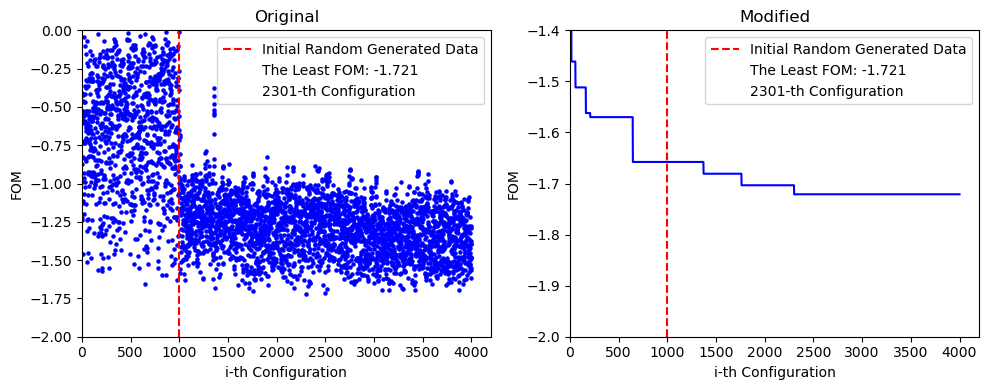

跑完全部的iteration啦!! 


In [22]:
# 初始化FM model（沒用dynamic_FM才需要）
if not use_dynamic_FM:
    model = FactorizationMachine(input_size=rings, factorization_size=K, act="identity")
    model.init_params(initializer=mx.init.Normal())
    # model.init_params(initializer=mx.init.Xavier())    # 之後dynamic_FM也試試這個
model.bqm()

# 刪除上次的best model（用dynamic_FM才需要）
if use_dynamic_FM:
    rm_best_model()

# 初始化存放FM loss的容器
training_losses = []
testing_losses  = []

# 初始化存放sampling energy, fom的容器（only for training set）
energy_ls = []
fom_ls    = []
num_in_iter = []    # 用來記錄每個iteration增加幾筆new data

# 建立存放Q matrix的資料夾 & 刪除之前的暫存檔
folder_name = "Q_matrix_temp"
os.makedirs(folder_name, exist_ok=True)
for file_path in glob.glob(os.path.join(folder_name, "*")):
    if os.path.isfile(file_path):
        os.remove(file_path)

# 開始跑整個FMQA的流程
i = 0
start_time = time.time()    # 計時開始（計整個訓練要跑的時間）
while i < iteration:
    
    # 顯示目前訓練的是第幾次iter (從1開始)
    print(f"第{i+1}次iteration")

    # Factorization Machine
    fm_training_time_start = time.time()    # FM計時開始
    if use_dynamic_FM:
        model = dynamic_FM(dynamic_retrain, rings, K, training_set, testing_set, show=True)
    else:
        model.train(configs_train, foms_train, num_epoch=num_epoch)
    fm_training_time_end   = time.time()    # FM計時結束
    print(f"訓練FM的時間: {fm_training_time_end - fm_training_time_start} 秒")    # 顯示FM的訓練時間

    training_losses.append( model.loss(training_set) )
    if testing_set[0].shape[0]:
        testing_losses.append( model.loss(testing_set) )

    # Q Matrix (從1開始)
    Q_matrix_start_time = time.time()
    path_fig  = os.path.join(folder_name, f"Q_matrix_{len(training_losses)}.png")    # 因為i可能被reset，所以這裡用training_losses有幾個元素來判斷實際是第幾次迴圈（從1開始）才正確
    path_data = os.path.join(folder_name, f"Q_matrix_{len(training_losses)}.npy")
    model.plot_Q_matrix(show_fig=False, path_fig=path_fig, save_fig=True, path_data=path_data, save_data=True)
    Q_matrix_end_time = time.time()
    print(f"畫Q Matrix的時間：{Q_matrix_end_time - Q_matrix_start_time} 秒")

    # 動態num_reads, num_adds
    if dynamic_sampling:
        dataset_size = len(training_set[0]) + len(testing_set[0])
        num_adds, num_reads = num_reads_adds_generator(dataset_size, num_adds_ratio, num_reads_ratio, num_adds_limit)
        print(f"num_adds = {num_adds}, num_reads = {num_reads}")
    
    # QUBO Sampling
    sampling_time_start = time.time()    # sampling計時開始
    if sampler_type == "Exact":
        sampleset = sampler.sample(model.bqm())
    elif sampler_type == "SA":
        sampleset = sampler.sample(model.bqm(), num_reads=num_reads)
    elif sampler_type == "QA":
        sampleset = sampler.sample(
                                model.bqm(),
                                num_reads=num_reads,
                                annealing_time=annealing_time,
                                label=task_name
                            )
    else:
        print("沒有這個sampler")
        sys.exit(1)
    sampling_time_end = time.time()    # sampling計時結束
    print(f"{sampler_type} sample的時間: {sampling_time_end - sampling_time_start} 秒")    # 顯示sampling時間
    # print(f"Sampler得出的energy: ", sampleset.record["energy"])    # num_reads多的時候不要顯示
    # print(f"Sample出的最低能量：{np.min(sampleset.record['energy'])}")
    
    new_data_time_start = time.time()
    if sampler_type == "Exact":
        # 因為exact solver比較不一樣，所以這裡自己實現new_configs, new_energies, new_foms -> 避免使用到add_new_data, sort_new_data函數
        # 這裡實現的是: min_fom
        # 方法：先挑出num_reads筆最小energies的組態（不重複），再從其中取出num_adds筆最小FOMs的組態
        configs_temp = sampleset.record["sample"]
        energies_temp = sampleset.record["energy"]
        smallest_energies_indices = np.argsort(energies_temp)[:num_reads]
        configs_temp = configs_temp[smallest_energies_indices]
        energies_temp = energies_temp[smallest_energies_indices]
        foms_temp = foms_calc(configs_temp, resolution, multiple, target)
        smallest_foms_indices = np.argsort(foms_temp)[:num_adds]
        new_configs  = configs_temp[smallest_foms_indices]
        new_energies = energies_temp[smallest_foms_indices]
        new_foms     = foms_temp[smallest_foms_indices]
    else:
        new_configs, new_energies, new_foms = add_new_data(add_method, sampleset, num_adds,
                                                           resolution=resolution, multiple=multiple, target=target)
    new_data_time_end = time.time()
    print(f"計算new data的時間: {new_data_time_end - new_data_time_start} 秒")

    # 不允許出現重複的數據(generated by Grok, haven't been tested much yet)
    # 待修正1：這邊僅先考慮只有training set的情況
    # 待修正2：這裡是在計算完foms才刪除的，如果要效率比較好應該在計算foms前就把重複的configs先刪除，但是因為add_new_data是直接傳sampleset造成實現上有點困難
    # Step 1: Remove duplicates within new_configs itself
    # Use unique with return_index to get indices of unique rows
    unique_indices = np.unique(new_configs, axis=0, return_index=True)[1]
    # Sort indices to maintain original order if needed
    unique_indices = np.sort(unique_indices)
    # Update all three arrays to remove self-duplicates
    new_configs = new_configs[unique_indices]
    new_energies = new_energies[unique_indices]
    new_foms = new_foms[unique_indices]
    # Step 2: Remove rows in new_configs that match any row in configs_train
    # Create a boolean mask for rows in new_configs that are not in configs_train
    mask = ~np.any(np.all(new_configs[:, None] == configs_train[None, :], axis=-1), axis=1)
    # Apply mask to all three arrays
    new_configs = new_configs[mask]
    new_energies = new_energies[mask]
    new_foms = new_foms[mask]

    # 顯示原先設定的新增筆數 & 實際新增的筆數
    print(f"原先設定的新增筆數: {num_adds}")
    print(f"最終實際新增的筆數: {len(new_configs)}（會因為簡併態、不允許重複數據而造成跟原先設定的筆數不同）")
    
    # 決定new data要怎麼新增到training, testing set，並且進行排序
    new_data_split_idx = math.ceil( len(new_configs) * new_data_split_ratio )    # 放到新training set的下標+1
    new_configs_train, new_configs_test   = new_configs[:new_data_split_idx], new_configs[new_data_split_idx:]
    new_energies_train, new_energies_test = new_energies[:new_data_split_idx], new_energies[new_data_split_idx:]
    new_foms_train, new_foms_test         = new_foms[:new_data_split_idx], new_foms[new_data_split_idx:]
    if "min_fom" == add_method:
        sort_method = "fom_ascent"
    elif "min_energy" == add_method:
        sort_method = "energy_ascent"
    else:
        sort_method = None
    if sampler_type != "Exact":
        new_configs_train, new_energies_train, new_foms_train = sort_new_data(sort_method, new_configs_train, new_energies_train, new_foms_train)
        new_configs_test, new_energies_test, new_foms_test    = sort_new_data(sort_method, new_configs_test, new_energies_test, new_foms_test)
    if len(new_foms_train):
        print(f"這個iter最小的foms_train: {np.min(new_foms_train)}")
    # # 刪除前xx%的原始數據（之後寫成函數）
    # xx = 0.1
    # n_remove_train = int(len(foms_train) * xx)
    # n_remove_test  = int(len(foms_test) * xx)
    # configs_train, configs_test = configs_train[n_remove_train:], configs_test[n_remove_test:]
    # foms_train, foms_test = foms_train[n_remove_train:], foms_test[n_remove_test:]
    # 新增到dataset
    configs_train, configs_test = np.r_[configs_train, new_configs_train], np.r_[configs_test, new_configs_test]
    foms_train, foms_test       = np.r_[foms_train, new_foms_train], np.r_[foms_test, new_foms_test]
    training_set, testing_set   = [configs_train, foms_train], [configs_test, foms_test]

    ################################對照exact##################################
    if rings <= 16:    # rings太大不要用到Exact Solver
        sampler_temp = dimod.ExactSolver()
        sampleset_temp = sampler_temp.sample(model.bqm())
        energy_temp = sampleset_temp.record["energy"]
        ascending_indices = np.argsort(energy_temp)
        energy_temp_sorted = energy_temp[ascending_indices]
    
        arr = find_indices(energy_temp_sorted, new_energies_train) + 1
        arr_str = ", ".join(map(str, arr))
        print(f"new energies實際上是第幾小的: [{arr_str}]")
        print(f"這些energies的值: [{', '.join(map(str, new_energies_train))}]")
        print(f"這些energies對應的FOM: [{', '.join(map(str, new_foms_train))}]")
    ###########################################################################
    
    # 紀錄所有新增的energies跟foms（只記錄training set的）
    energy_ls.extend( new_energies_train )
    fom_ls.extend( new_foms_train )
    if len(num_in_iter) == 0:
        num_in_iter.append( new_data_split_idx )
    else:
        num_in_iter.append( num_in_iter[-1] + new_data_split_idx )
    
    # 分割線
    print("*" * 50)
    
    # 自增1
    i += 1

    # 跑完指定的iteration
    # if i >= iteration:
        
    #     # 計時結束
    #     end_time = time.time()
    #     elapsed_time = end_time - start_time
    #     print(f"跑完所有iteration的時間: {elapsed_time: .2f} 秒")

    #     # 顯示整個iteration的loss
    #     if testing_losses:
    #         plot_loss_iter(training_losses, testing_losses)
        
    #     # 顯示energy - ith config, fom - ith config
    #     plot_energy_fom(energy_ls, fom_ls, num_in_iter, show=True, save=False)
        
    #     # 顯示FOMs對i-th configuration的圖 & 最小FOM的configuration資訊
    #     print(f"最小的fom是: {np.min(foms_train)}")
    #     print(f"他的index是: {np.argmin(foms_train)}")
    #     print(f"這個fom對應的config是: [{', '.join(map(str, configs_train[np.argmin(foms_train)]))}]")
    #     plot_foms(foms_train, split_idx=split_idx, original=True, modified=True, show=True)
        
    #     # 詢問還要跑幾次，如果不要跑了就輸入0
    #     iteration = int( input("還要跑幾次iteration: ") )
    #     i = 0
    #     start_time = time.time()


# 顯示FOMs對i-th configuration的圖 & 最小FOM的configuration資訊
print(f"最小的fom是: {np.min(foms_train)}")
print(f"他的index是: {np.argmin(foms_train)}")
print(f"這個fom對應的config是: [{', '.join(map(str, configs_train[np.argmin(foms_train)]))}]")
plot_foms(foms_train, split_idx=split_idx, original=True, modified=True, show=True)
with open('1000+10x300.txt', 'a') as f:
    f.write(str(np.min(foms_train)) + '\n')
    f.close()

print("跑完全部的iteration啦!! ")

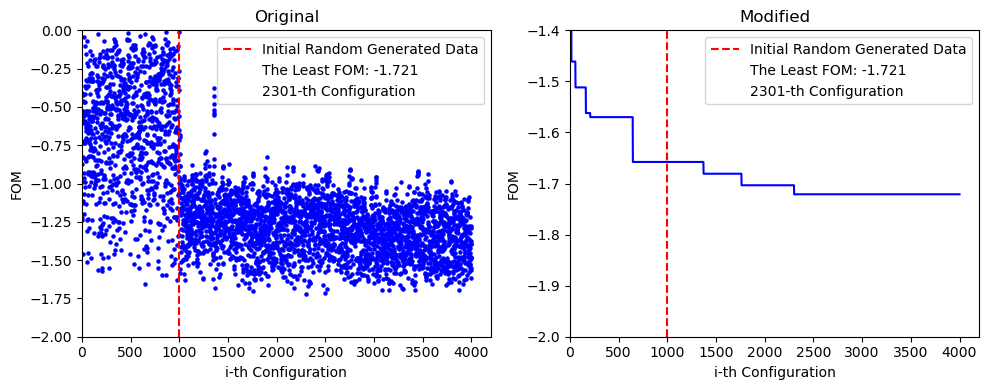

In [23]:
plot_foms(foms_train, split_idx=split_idx, original=True, modified=True, show=True)

# Unit Test

## Test the function "foms_calc"

In [24]:
# foms = foms_calc(configs_train, resolution, multiple, target)

In [25]:
# idx = 40
# print(f"[{', '.join(map(str, configs_train[idx]))}]")
# print(foms[idx])

## Test the functions "add_new_data" & "sort_new_data"

In [26]:
# # Initialize the model
# model = FactorizationMachine(input_size=rings, factorization_size=K, act="identity")
# model.init_params(initializer=mx.init.Normal())

# # Training the model
# model.train(configs_train, foms_train, num_epoch=num_epoch)

In [27]:
# num_reads = 10
# num_adds  = 3
# add_method  = "min_fom"
# sort_method = "fom_ascent"

# # SA
# sampler = dimod.SimulatedAnnealingSampler()
# sampleset = sampler.sample(model.bqm(), num_reads=num_reads)
# foms = foms_calc(sampleset.record["sample"], resolution, multiple, target)

In [28]:
# def print_configs(configs):
#     for i, config in enumerate(configs):
#         print(f"{i+1}. [{', '.join(map(str, config))}]")

In [29]:
# # original
# print_configs(sampleset.record["sample"])
# print(sampleset.record["energy"])
# print(foms)
# print("*" * 50)

# # add_new_data
# new_configs, new_energies, new_foms = add_new_data(add_method, sampleset, num_adds, resolution=resolution, multiple=multiple, target=target)
# print_configs(new_configs)
# print(new_energies)
# print(new_foms)
# print("*" * 50)

# # sort_new_data
# new_configs, new_energies, new_foms = sort_new_data(sort_method, new_configs, new_energies, new_foms)
# print_configs(new_configs)
# print(new_energies)
# print(new_foms)

## Test the "original FM" & the function "dynamic_FM"
<pre>
- Examine the time for training when the dataset is large
- Examine the time for saving model when the dataset is large
- Test if the method "load_model" works well
- Test if the function "dynamic_FM" works well
</pre>

### Define some functions

In [30]:
# 查看模型參數的說明 -> "for name, param in model.collect_params().items()"這個loop會隨著training set越大而跑的越慢
################################################################################################################
# def inspect_model_params(model):
#     total_size = 0
#     print("Model parameters:")
    
#     for name, param in model.collect_params().items():
#         if param.grad_req != 'null':  # 確保是可訓練參數
#             param_data = param.data()
#             param_size = param_data.size * np.dtype(param_data.dtype).itemsize  # 計算記憶體大小 (bytes)
#             total_size += param_size
#             print(f" - {name}: shape={param.shape}, size={param_data.size}, memory={param_size / 1024:.2f} KB")

#     print(f"Total parameter memory: {total_size / (1024 * 1024):.2f} MB")
################################################################################################################
# def inspect_model_params(model):
#     mx.nd.waitall()  # 確保所有運算完成，避免阻塞
#     total_size = 0
#     print("Model parameters:")

#     for name, param in model.collect_params().items():
#         param_data = param.data(ctx=mx.cpu())  # 確保不會觸發 GPU → CPU 傳輸
#         param_size = param_data.size * np.dtype(param_data.dtype).itemsize
#         total_size += param_size
#         print(f" - {name}: shape={param.shape}, size={param_data.size}, memory={param_size / 1024:.2f} KB")

#     print(f"Total parameter memory: {total_size / (1024 * 1024):.2f} MB")

In [31]:
# # 查看模型參數的內容
# def show_model_parameters(model):
#     mx.nd.waitall()  # 確保所有運算完成，避免阻塞
#     print("Model parameters:")
#     for name, param in model.collect_params().items():
#         param_data = param.data(ctx=mx.cpu()).asnumpy()  # 轉換為 NumPy 陣列以便顯示
#         print(f" - {name}:")
#         print(param_data)  # 直接輸出完整參數值
#         print()  # 增加換行方便閱讀

In [32]:
# 使用pickle存模型 -> 結果：large dataset訓練出來的model還是存很久

# def save_params_pickle(model, path="model.pkl"):
#     param_dict = {name: param for name, param in model.collect_params().items()}
#     with open(path, "wb") as f:
#         pickle.dump(param_dict, f)
#     print(f"Saved model parameters to {path}")

# def load_params_pickle(model, path="model.pkl"):
#     with open(path, "rb") as f:
#         param_dict = pickle.load(f)
#     for name, param in model.collect_params().items():
#         if name in param_dict:
#             param.set_data(param_dict[name].data())
#     print(f"Loaded model parameters from {path}")

In [33]:
# 使用numpy存模型 -> 結果：large dataset訓練出來的model還是存很久

# def save_params_manual(model, path="manual_model.npz"):
#     """手動儲存模型參數"""
#     param_dict = {name: param.data().asnumpy() for name, param in model.collect_params().items()}
#     np.savez(path, **param_dict)
#     print(f"Saved model parameters to {path}")

# def load_params_manual(model, path="manual_model.npz"):
#     """手動載入模型參數"""
#     loaded_data = np.load(path)
#     for name, param in model.collect_params().items():
#         if name in loaded_data:
#             param.set_data(mx.nd.array(loaded_data[name]))
#     print(f"Loaded model parameters from {path}")

### Examine the training & saving parameters time

In [34]:
# var_num = 64
# K = var_num
# dataset_size = 200_000
# xs = np.random.randint(2, size=(dataset_size, var_num), dtype=np.int8)
# ys = np.empty(dataset_size, dtype=np.float64)
# split_idx = int( dataset_size / 2)
# training_set = [xs[:split_idx], ys[:split_idx]]
# testing_set  = [xs[split_idx:], ys[split_idx:]]

In [35]:
# model = FactorizationMachine(input_size=var_num, factorization_size=K, act="identity")
# model.init_params(initializer=mx.init.Normal())

# start_time = time.time()
# model.train(xs, ys, num_epoch=100)
# # model = dynamic_FM(var_num, K, training_set, testing_set, show=False)
# end_time = time.time()
# print(f"training time: {end_time - start_time}")

# start_time = time.time()
# model.save_parameters("temp.params")
# end_time = time.time()
# print(f"saving time: {end_time - start_time}")

### Test if the method "load_model" works well

In [36]:
# var_num = 3
# K = var_num

# dataset_size = 20_000
# xs = np.random.randint(2, size=(dataset_size, var_num), dtype=np.int8)
# ys = np.empty(dataset_size, dtype=np.float64)

In [37]:
# model = FactorizationMachine(input_size=var_num, factorization_size=K, act="identity")
# model.init_params(initializer=mx.init.Normal())
# show_model_parameters(model)

# model.train(xs, ys)

# show_model_parameters(model)
# model.save_model("temp.params")

In [38]:
# model = FactorizationMachine.load_model(var_num, K, "temp.params")
# show_model_parameters(model)

### Test if the function "dynamic_FM" works well

In [39]:
# dynamic_retrain = True
# model = dynamic_FM(dynamic_retrain, rings, K, training_set, testing_set, show=True)

In [40]:
# # rm_best_model()
# dynamic_retrain = False
# model = dynamic_FM(dynamic_retrain, rings, K, training_set, testing_set, show=True)

In [41]:
s4_multilayer_FOM([1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0])

-1.7656853484641264

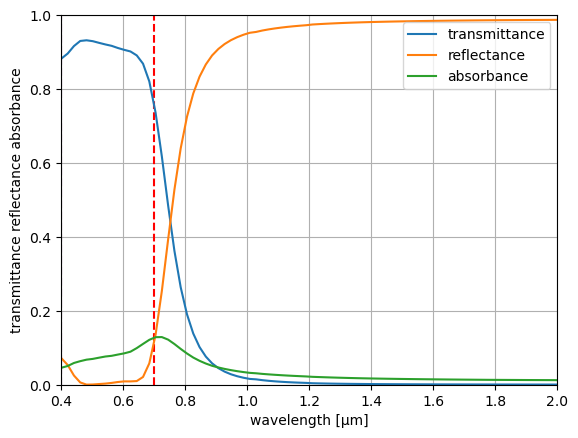

0.9012267738395401
0.9202763371957037


-1.7656853484641264

In [42]:
total_layer = 30
print_spectrum = 1
print_TR_percent = 1
sio2_thick = 0.01
ag_thick = 0.005
hfo2_thick = 0.01
al2o3_thick = 0.01
al_thick = 0.005
def n_al2o3(wl):
    nsq = 1 + 1.4313493*wl**2/(wl**2-0.0726631**2) + 0.65054713*wl**2/(wl**2-0.1193242**2) + 5.3414021*wl**2/(wl**2-18.028251**2)
    return (nsq)
def n_sio2(wl):
    nsq = 1 + 0.6961663*wl**2/(wl**2-0.0684043**2) + 0.4079426*wl**2/(wl**2-0.1162414**2) + 0.8974794*wl**2/(wl**2-9.896161**2)
    return (nsq)
def n_hfo2(wl):
    return (np.square(1.875 + 6.28e-3/(wl**2) + 5.8e-4/(wl**4)))

def s4_multilayer_FOM(x):
    #新しいシミュレーションオブジェクトを設定
    S=S4.New(Lattice=((1,0),(0,1)),NumBasis=1)
    #S.SetOptions(PolarizationDecomposition = True)
    pmma_string = 'PMMA'
    sio2_string = 'SiO2'
    sic_string  = 'SiC' 
    #materialの設定
    S.SetMaterial(Name='Vacuum',Epsilon=1)
    S.SetMaterial(Name='Si',Epsilon=3.4**2)
    S.SetMaterial(Name='SiO2',Epsilon=1.5**2)
    S.SetMaterial(Name='SiC',Epsilon=3.0**2)
    S.SetMaterial(Name='PMMA',Epsilon=1.48**2)
    S.SetMaterial(Name='Ag',Epsilon=5**2)
    S.SetMaterial(Name='HfO2',Epsilon=5**2)
    S.SetMaterial(Name='Al2O3',Epsilon=5**2)
    S.SetMaterial(Name='Al',Epsilon=5**2)
    #レイヤーを設定今回は3つのレイヤー。
   
        
        
    S.AddLayer(Name='Level0',Thickness=0.0, Material='Vacuum')
    
    if(x[(total_layer-4)*2]==0 and x[(total_layer-4)*2+1]==0):
        sio2_thick = 0.005
    elif(x[(total_layer-4)*2]==0 and x[(total_layer-4)*2+1]==1):
        sio2_thick = 0.01
    elif(x[(total_layer-4)*2]==1 and x[(total_layer-4)*2+1]==0):
        sio2_thick = 0.015
    elif(x[(total_layer-4)*2]==1 and x[(total_layer-4)*2+1]==1):
        sio2_thick = 0.02

    if(x[(total_layer-3)*2]==0 and x[(total_layer-3)*2+1]==0):
        ag_thick = 0.005
    elif(x[(total_layer-3)*2]==0 and x[(total_layer-3)*2+1]==1):
        ag_thick = 0.006
    elif(x[(total_layer-3)*2]==1 and x[(total_layer-3)*2+1]==0):
        ag_thick = 0.007
    elif(x[(total_layer-3)*2]==1 and x[(total_layer-3)*2+1]==1):
        ag_thick = 0.008

    if(x[(total_layer-2)*2]==0 and x[(total_layer-2)*2+1]==0):
        hfo2_thick = 0.005
    elif(x[(total_layer-2)*2]==0 and x[(total_layer-2)*2+1]==1):
        hfo2_thick = 0.01
    elif(x[(total_layer-2)*2]==1 and x[(total_layer-2)*2+1]==0):
        hfo2_thick = 0.015
    elif(x[(total_layer-2)*2]==1 and x[(total_layer-2)*2+1]==1):
        hfo2_thick = 0.02

    if(x[(total_layer-1)*2]==0 and x[(total_layer-1)*2+1]==0):
        al2o3_thick = 0.005
    elif(x[(total_layer-1)*2]==0 and x[(total_layer-1)*2+1]==1):
        al2o3_thick = 0.01
    elif(x[(total_layer-1)*2]==1 and x[(total_layer-1)*2+1]==0):
        al2o3_thick= 0.015
    elif(x[(total_layer-1)*2]==1 and x[(total_layer-1)*2+1]==1):
        al2o3_thick = 0.02
    
        
    
    
    for layercount in range(total_layer-4):
        if(x[layercount]==0 and x[layercount+total_layer-4]==0):
            S.AddLayer(Name=str(layercount), Thickness=sio2_thick, Material='SiO2')
        elif(x[layercount]==0 and x[layercount+total_layer-4]==1):
            S.AddLayer(Name=str(layercount), Thickness=ag_thick, Material='Ag')
        elif(x[layercount]==1 and x[layercount+total_layer-4]==0):
            S.AddLayer(Name=str(layercount), Thickness=hfo2_thick, Material='HfO2')
        elif(x[layercount]==1 and x[layercount+total_layer-4]==1):
            S.AddLayer(Name=str(layercount), Thickness=al2o3_thick, Material='Al2O3')
    
   
    
    
    S.AddLayer(Name='Air',Thickness=0.0,Material='Vacuum')
    #S.AddLayerCopy(Name = 'Air', Thickness = 0.0, Layer = 'Level0')
    
    #波長範囲を設定
    wavelength_array=np.linspace(0.4,2,80)
    #print(wavelength_array)
    wavelength_array_inside = [0.4      , 0.42025316, 0.44050633, 0.46075949, 0.48101266,
                               0.50126582, 0.52151899, 0.54177215, 0.56202532, 0.58227848,
                               0.60253165, 0.62278481, 0.64303797, 0.66329114, 0.6835443,  0.70379747 ]
    wavelength_array_outside1 = [0.72405063 ,0.7443038
                                ,0.76455696 ,0.78481013, 0.80506329, 0.82531646, 0.84556962, 0.86582278
                                ,0.88607595 ,0.90632911, 0.92658228, 0.94683544, 0.96708861, 0.98734177
                                ,1.00759494 ,1.0278481 , 1.04810127, 1.06835443, 1.08860759, 1.10886076
                                ,1.12911392 ,1.14936709, 1.16962025, 1.18987342, 1.21012658, 1.23037975
                                ,1.25063291 ,1.27088608, 1.29113924, 1.31139241, 1.33164557, 1.35189873
                                ,1.3721519  ,1.39240506, 1.41265823, 1.43291139, 1.45316456, 1.47341772
                                ,1.49367089 ,1.51392405, 1.53417722, 1.55443038, 1.57468354, 1.59493671
                                ,1.61518987 ,1.63544304, 1.6556962 , 1.67594937, 1.69620253, 1.7164557
                                ,1.73670886 ,1.75696203, 1.77721519, 1.79746835, 1.81772152, 1.83797468
                                ,1.85822785 ,1.87848101, 1.89873418, 1.91898734, 1.93924051, 1.95949367
                                ,1.97974684 ,2.0        ]
    Planck_array = np.array( [72203 , 100131, 133343, 171499, 214049,
                                       260285, 309395, 360519, 412793, 465387,
                                       517531, 568535, 617802, 664829, 709210,
                                       750632, 788866, 823761, 855234, 883262,
                                       907872, 929131, 947141, 962029, 973942,
                                       983041, 989499, 993489, 995191, 994782,
                                       992435, 988321, 982603, 975436, 966971,
                                       957346, 946694, 935139, 922796,
                                       909770, 889167, 874851, 860165, 845182,
                                       829968, 814583, 799083, 783516, 767926, 
                                       752353, 736833, 721398, 706074, 690887, 
                                       675859, 661007, 646350, 631899, 617669,
                                       603668, 589905, 576386, 563118, 550104,
                                       537348, 524850, 512613, 500637, 488921,
                                       477464, 466265, 455321, 444631, 434190,
                                       423997, 414047, 404336, 394862, 385619,
                                       372180])
    Planck_normalized_array = Planck_array#/9.95282
    
    #効率計算結果用アレイ
    efficiency_array=[]
    reflected_flux_array = []
    emissive_array = []
    reflected_flux_array_outside1 = []
    reflected_flux_array_outside2 = []
    reflected_flux_array_inside = []
    efficiency_array_outside = []
    reflected_flux_outside  = []
    efficiency_array_inside = []
    reflected_flux_inside = [] 

    HfO2_array = [
        
    ]
    Al2O3_array = [
        
    ]
    
    SiC_array = [11.959+ 4.7869j
    ,11.893+ 4.3625j
    ,11.851+ 4.0079j
    ,11.816+ 3.6938j
    ,11.794+ 3.3971j
    ,11.756+ 3.1279j
    ,11.714+ 2.8820j
    ,11.665+ 2.6576j
    ,11.614+ 2.4576j
    ,11.561+ 2.2745j
    ,11.510+ 2.1070j
    ,11.456+ 1.9535j
    ,11.393+ 1.8099j
    ,11.337+ 1.6870j
    ,11.281+ 1.5770j
    ,11.227+ 1.4723j
    ,11.179+ 1.3799j
    ,11.128+ 1.2891j
    ,11.082+ 1.2112j
    ,11.036+ 1.1316j
    ,10.982+ 1.0604j
    ,10.932+ 1.0079j
    ,10.898+ 0.9507j
    ,10.846+ 0.9045j
    ,10.815+ 0.8471j
    ,10.776+ 0.8223j
    ,10.759+ 0.7672j
    ,10.726+ 0.7301j
    ,10.689+ 0.6723j
    ,10.655+ 0.6473j
    ,10.620+ 0.6224j
    ,10.586+ 0.5976j
    ,10.552+ 0.5728j
    ,10.525+ 0.5513j
    ,10.504+ 0.5325j
    ,10.483+ 0.5137j
    ,10.462+ 0.4949j
    ,10.441+ 0.4762j
    ,10.420+ 0.4575j
    ,10.403+ 0.4402j
    ,10.378+ 0.4150j
    ,10.362+ 0.3983j
    ,10.346+ 0.3816j
    ,10.330+ 0.3649j
    ,10.313+ 0.3483j
    ,10.297+ 0.3317j
    ,10.283+ 0.3206j
    ,10.269+ 0.3098j
    ,10.256+ 0.2990j
    ,10.242+ 0.2882j
    ,10.228+ 0.2774j
    ,10.214+ 0.2667j
    ,10.201+ 0.2559j
    ,10.187+ 0.2452j
    ,10.173+ 0.2345j
    ,10.161+ 0.2262j
    ,10.151+ 0.2197j
    ,10.141+ 0.2132j
    ,10.131+ 0.2068j
    ,10.121+ 0.2003j
    ,10.111+ 0.1939j
    ,10.101+ 0.1874j
    ,10.091+ 0.1810j
    ,10.081+ 0.1746j
    ,10.071+ 0.1682j
    ,10.061+ 0.1618j
    ,10.051+ 0.1554j
    ,10.041+ 0.1491j
    ,10.032+ 0.1438j
    ,10.023+ 0.1385j
    ,10.014+ 0.1333j
    ,10.006+ 0.1280j
    ,9.9969+ 0.1227j
    ,9.9881+ 0.1175j
    ,9.9794+ 0.1123j
    ,9.9711+ 0.1084j
    ,9.9631+ 0.1052j
    ,9.9552+ 0.1020j
    ,9.9472+ 0.0988j
    ,9.9352+ 0.0941j ]


    
    Ag_array= [-4.5730+0.23090j
    ,-5.6067+0.23916j
    ,-6.6569+0.26761j
    ,-7.7231+0.28956j
    ,-8.8055+0.31331j
    ,-9.9352+0.32785j
    ,-11.090+0.34592j
    ,-12.289+0.36117j
    ,-13.543+0.36946j
    ,-14.821+0.38399j
    ,-16.151+0.39432j
    ,-17.535+0.40347j
    ,-18.957+0.42822j
    ,-20.420+0.45177j
    ,-21.924+0.47418j
    ,-23.468+0.49476j
    ,-25.059+0.51481j
    ,-26.693+0.53629j
    ,-28.375+0.55852j
    ,-30.100+0.58312j
    ,-31.866+0.61038j
    ,-33.683+0.63822j
    ,-35.549+0.67139j
    ,-37.465+0.70572j
    ,-39.431+0.74107j
    ,-41.420+0.78426j
    ,-43.458+0.82865j
    ,-45.545+0.87425j
    ,-47.674+0.92080j
    ,-49.850+0.96840j
    ,-52.074+ 1.0172j
    ,-53.460+ 1.0477j
    ,-55.726+ 1.1005j
    ,-58.023+ 1.1600j
    ,-60.367+ 1.2209j
    ,-62.757+ 1.2833j
    ,-65.194+ 1.3472j
    ,-67.662+ 1.4124j
    ,-70.16 + 1.4790j
    ,-72.720+ 1.5471j
    ,-76.633+ 1.6519j
    ,-79.299+ 1.7237j
    ,-82.011+ 1.7961j
    ,-84.770+ 1.8692j
    ,-87.574+ 1.9437j
    ,-90.417+ 2.0197j
    ,-93.284+ 2.0975j
    ,-96.196+ 2.1768j
    ,-99.152+ 2.2574j
    ,-102.17+ 2.3447j
    ,-105.25+ 2.4370j
    ,-108.37+ 2.5310j
    ,-111.54+ 2.6267j
    ,-114.74+ 2.7251j
    ,-117.96+ 2.8261j
    ,-121.23+ 2.9289j
    ,-124.54+ 3.0334j
    ,-127.90+ 3.1397j
    ,-131.30+ 3.2501j
    ,-134.75+ 3.3624j
    ,-138.24+ 3.4765j
    ,-141.78+ 3.5924j
    ,-145.36+ 3.7101j
    ,-149.02+ 3.8350j
    ,-152.72+ 3.9628j
    ,-156.47+ 4.0926j
    ,-160.27+ 4.2244j
    ,-164.11+ 4.3581j
    ,-168.00+ 4.4938j
    ,-171.87+ 4.6422j
    ,-175.79+ 4.7935j
    ,-179.74+ 4.9470j
    ,-183.75+ 5.1026j
    ,-187.80+ 5.2605j
    ,-191.89+ 5.4206j
    ,-196.02+ 5.5846j
    ,-200.20+ 5.7602j
    ,-204.42+ 5.9382j
    ,-208.69+ 6.1187j
    ,-215.17+ 6.3940j]
    
    SiO2_array =[2.2025+0.0j
    ,2.1968+0.0j
    ,2.1920+0.0j
    ,2.1878+0.0j
    ,2.1841+0.0j
    ,2.1809+0.0j
    ,2.1781+0.0j           
    ,2.1755+0.0j          
    ,2.1733+0.0j          
    ,2.1713+0.0j
    ,2.1695+0.0j
    ,2.1679+0.0j
    ,2.1664+0.0j
    ,2.1650+0.0j
    ,2.1638+0.0j
    ,2.1627+0.0j
    ,2.1617+0.0j
    ,2.1608+0.0j
    ,2.1599+0.0j
    ,2.1591+0.0j
    ,2.1584+0.0j
    ,2.1577+0.0j
    ,2.1571+0.0j
    ,2.1565+0.0j
    ,2.1559+0.0j
    ,2.1553+0.0j
    ,2.1547+0.0j
    ,2.1541+0.0j
    ,2.1535+0.0j
    ,2.1529+0.0j
    ,2.1523+0.0j
    ,2.1517+0.0j
    ,2.1511+0.0j
    ,2.1505+0.0j
    ,2.1499+0.0j
    ,2.1493+0.0j
    ,2.1487+0.0j
    ,2.1481+0.0j
    ,2.1475+0.0j
    ,2.1471+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j
    ,2.1467+0.0j ] 
    
    Al_array= [-23.144+4.7182j
    ,-25.589+5.5127j
    ,-28.145+6.4195j
    ,-30.731+7.4949j
    ,-33.395+8.6579j
    ,-36.090+9.9091j
    ,-38.872+11.265j
    ,-41.710+12.807j
    ,-44.643+14.429j
    ,-47.493+16.359j
    ,-50.406+18.401j
    ,-53.354+20.582j
    ,-56.098+23.131j
    ,-58.640+25.854j
    ,-60.999+28.736j
    ,-62.933+31.901j
    ,-64.704+35.228j
    ,-65.238+38.813j
    ,-65.274+42.509j
    ,-63.977+45.423j
    ,-61.615+46.062j
    ,-60.201+45.005j
    ,-59.941+42.950j
    ,-60.318+39.930j
    ,-60.709+36.927j
    ,-64.186+33.671j
    ,-68.333+30.708j
    ,-73.343+28.403j
    ,-79.497+27.064j
    ,-84.779+27.151j
    ,-89.852+27.369j
    ,-94.605+27.627j
    ,-99.324+27.942j
    ,-104.10+28.269j
    ,-108.98+28.581j
    ,-113.97+28.880j
    ,-119.06+29.192j
    ,-124.15+29.750j
    ,-129.35+30.306j
    ,-134.66+30.861j
    ,-140.07+31.413j
    ,-145.58+31.964j
    ,-151.15+32.680j
    ,-156.77+33.553j
    ,-162.49+34.436j
    ,-168.31+35.329j
    ,-174.24+36.232j
    ,-180.27+37.144j
    ,-186.40+38.067j
    ,-192.48+39.216j
    ,-198.61+40.462j
    ,-204.83+41.728j
    ,-211.15+43.014j
    ,-217.57+44.319j
    ,-224.08+45.644j
    ,-230.68+46.988j
    ,-237.38+48.351j
    ,-244.13+49.796j
    ,-250.78+51.470j
    ,-257.53+53.171j
    ,-264.36+54.898j
    ,-271.28+56.653j
    ,-278.29+58.434j
    ,-285.39+60.242j
    ,-292.58+62.077j
    ,-299.86+63.938j
    ,-307.23+65.826j
    ,-314.69+67.741j
    ,-322.14+69.745j
    ,-329.44+71.924j
    ,-336.83+74.134j
    ,-344.29+76.375j
    ,-351.84+78.647j
    ,-359.47+80.951j
    ,-367.18+83.286j
    ,-374.97+85.652j
    ,-382.84+88.049j
    ,-390.79+90.477j
    ,-398.83+92.936j
    ,-406.95+95.427j    ]
    SiO2_array_index = 0
    SiC_array_index = 0
    Ag_array_index = 0
    HfO2_array_index = 0
    Al2O3_array_index = 0
    Al_array_index = 0
    Planck_normalized_array_index = 0
    for wavelength in wavelength_array:
       
        S.SetMaterial(Name='SiO2',Epsilon=SiO2_array[SiO2_array_index])
        SiO2_array_index = SiO2_array_index + 1
        S.SetMaterial(Name='SiC',Epsilon=SiC_array[SiC_array_index])
        SiC_array_index = SiC_array_index + 1
        S.SetMaterial(Name='Ag',Epsilon=Ag_array[Ag_array_index])
        Ag_array_index = Ag_array_index + 1
        S.SetMaterial(Name='HfO2',Epsilon=n_hfo2(wavelength))
        HfO2_array_index = HfO2_array_index + 1
        S.SetMaterial(Name='Al2O3',Epsilon=n_al2o3(wavelength))
        Al2O3_array_index = Al2O3_array_index + 1
        S.SetMaterial(Name='Al',Epsilon=Al_array[Al_array_index])
        Al_array_index = Al_array_index + 1
        S.SetFrequency((1/wavelength))
    
        #入射角0度のs偏光平面波を入射する。
        S.SetExcitationPlanewave(IncidenceAngles=(0,0),sAmplitude=0,pAmplitude=1)
        
        #入射フラックスを取得
        (P_incident,P_reflect)=S.GetPowerFlux(Layer='Level0')
        
        #各次数の透過フラックスを取得
        #P_transmittance=S.GetPowerFluxByOrder(Layer='Air')
        (P_air_transmittance,P_air_reflect) =S.GetPowerFlux(Layer='Air')
        #1次回折光の効率になおす。
        #efficiency=(P_transmittance[1][0]/P_incident).real
        #Note that efficiency => transmittance
        efficiency=(P_air_transmittance/P_incident).real
        #efficiency=-(P_reflect/P_incident).real
        #アレイに追加。
        efficiency_array.append(efficiency)
        reflected_flux = (-(P_reflect/P_incident)).real
        reflected_flux_array.append(reflected_flux)
        #emissive = (1-((P_incident + P_reflect - P_air_transmittance)/P_incident)).real
        emissive = (1 - efficiency - reflected_flux )
        #emissive = ( efficiency)
        emissive_array.append(emissive)
        
        if(0.71<=wavelength<=2):
            reflected_flux_array_outside1.append((emissive)*Planck_normalized_array[Planck_normalized_array_index])
            efficiency_array_outside.append(efficiency)
            reflected_flux_outside.append(reflected_flux)
        elif(0<wavelength<0.71):
            reflected_flux_array_inside.append((emissive)*Planck_normalized_array[Planck_normalized_array_index])
            efficiency_array_inside.append(efficiency)
            reflected_flux_inside.append(reflected_flux)
            
        Planck_normalized_array_index = Planck_normalized_array_index +1
        #進捗表示。
        #sys.stdout.write(f"\r wavelength={wavelength} eff={emissive}")
        #sys.stdout.flush()
    
    #matplotlibで表示
    if(print_spectrum):
        plt.grid()
        plt.xlabel('wavelength [μm]')
        plt.ylabel('transmittance reflectance absorbance')
        plt.vlines(x = 0.4, ymin = 0, ymax = 1, colors = 'purple',linestyle='dashed')
        plt.vlines(x = 0.7, ymin = 0, ymax = 1, colors = 'red',linestyle='dashed')
        plt.plot(wavelength_array,efficiency_array , label = 'transmittance')
        plt.plot(wavelength_array,reflected_flux_array, label = 'reflectance')
        plt.plot(wavelength_array,emissive_array, label = 'absorbance')
        plt.xlim([0.4,2])
        plt.ylim([0,1])
        plt.legend()
        plt.show()
    
    planck_1_8 = 20.5066#/9.95282
    planck_8_13 = 47.1002#/9.95282
    planck_13_20 = 40.2612#/9.95282
    planck_inside =  120571
    planck_outside = 954989 
    planck_all_window = integrate.simps(Planck_normalized_array, wavelength_array)
    all_window = integrate.simps(emissive_array, wavelength_array)
    insidewindows = integrate.simps(reflected_flux_array_inside, wavelength_array_inside)
    outsidewindows1 = integrate.simps(reflected_flux_array_outside1, wavelength_array_outside1)
    
    insidewindows_T = integrate.simps(efficiency_array_inside, wavelength_array_inside)
    outsidewindows1_T = integrate.simps(efficiency_array_outside, wavelength_array_outside1)
    insidewindows_R = integrate.simps(reflected_flux_inside, wavelength_array_inside)
    outsidewindows1_R = integrate.simps(reflected_flux_outside, wavelength_array_outside1)
    if(print_TR_percent):
        print(insidewindows_T/0.303 )
        print(outsidewindows1_R/1.297)
    return (-(insidewindows_T/0.303 - outsidewindows1_T/1.297+ outsidewindows1_R/1.297 - insidewindows_R/0.303))
s4_multilayer_FOM([1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0])